In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import joblib

In [2]:
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels
features = []
labels = []
image_names = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_names.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_names = np.hstack(image_names)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_names
})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [3]:
# Function to print class distribution
def print_class_distribution(df, name):
    class_counts = df['labels'].value_counts()
    print(f"\n{name} Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

# Function to print class distribution by island
def print_class_distribution_by_island(df, name):
    class_counts = df.groupby(['image_name', 'labels']).size().unstack(fill_value=0)
    class_counts['island'] = class_counts.index.map(lambda x: extract_island_and_date(x)[0])
    print(f"\n{name} Class Distribution by Island:")
    print(class_counts)

# Custom train-test split function
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        
        # Ensure all classes are in the training set
        if set(train_df['labels'].unique()) == set(df['labels'].unique()):
            # Ensure all islands are in the training set
            train_islands = set(train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]))
            all_islands = set(df['image_name'].apply(lambda x: extract_island_and_date(x)[0]))
            if train_islands == all_islands:
                return train_df, test_df
    
    raise ValueError("Could not find a split that satisfies all conditions")

# Split the data
train_df, test_df = custom_train_test_split(dataset)

# Print class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")
print_class_distribution_by_island(train_df, "Training")


Training Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10

Training Class Distribution by Island:
labels                                              freshwater    ice  ocean  \
image_name                                                                     
C:\Users\Student\Documents\101_walrus_data\trai...        5472  34576  52416   
C:\Users\Student\Documents\101_walrus_data\trai...       17816  33391  95491   
C:\Users\Student\Documents\101_walrus_data\trai...        3036  58257  75513   
C:\Users\Student\Documents\101_walrus_data\trai...        1243  30323  28051   
C:\Users\Student\Documents\101_walrus_data\trai...         203   9680  44240   
C:\Users\Student\Documents\101_walrus_data\trai...           0   2230  19062   
C:\Users\Student\Documents\101_walrus_data\trai...           0   1220  10432   
C:\Use

In [4]:
# Prepare features and labels for training
X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name'])
y_train = train_df['encoded_labels']
X_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name'])
y_test = test_df['encoded_labels']

# Train the Random Forest model (default, unweighted)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, "RF_allislands_unweighted_2606.joblib")


['RF_allislands_unweighted_2606.joblib']

Accuracy: 0.9892
Precision: 0.9891
Recall: 0.9892
F1 Score: 0.9890
Cohen's Kappa: 0.9791

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.89      0.90      8050
         ice       0.98      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.98     18572
walrus_mixed       0.96      0.26      0.41       165
 walrus_pure       1.00      1.00      1.00        10

    accuracy                           0.99    242700
   macro avg       0.97      0.85      0.88    242700
weighted avg       0.99      0.99      0.99    242700


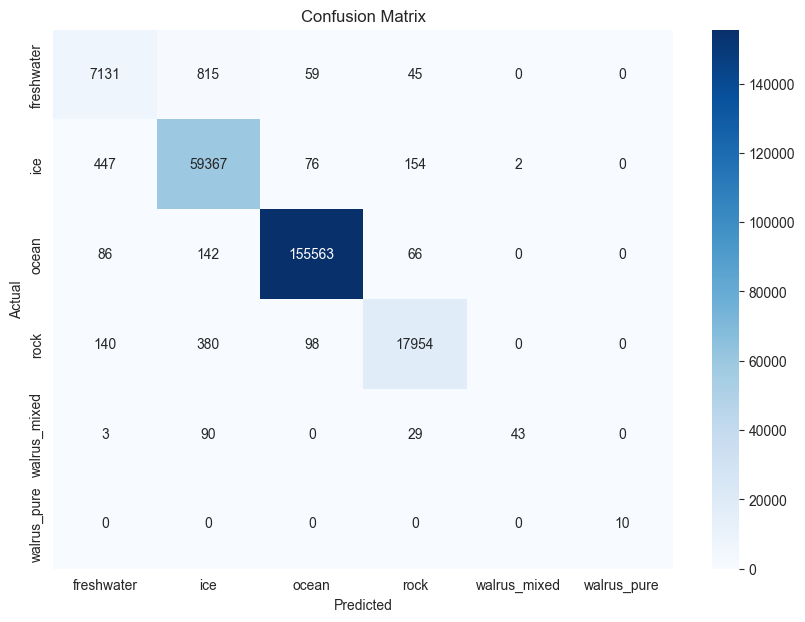

In [5]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fit

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


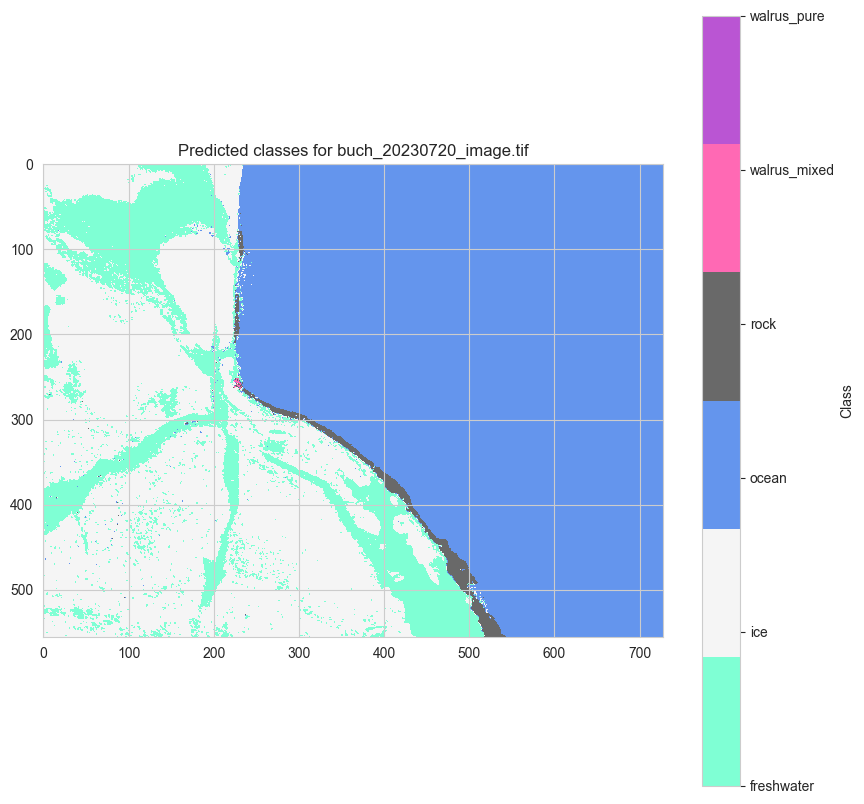

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


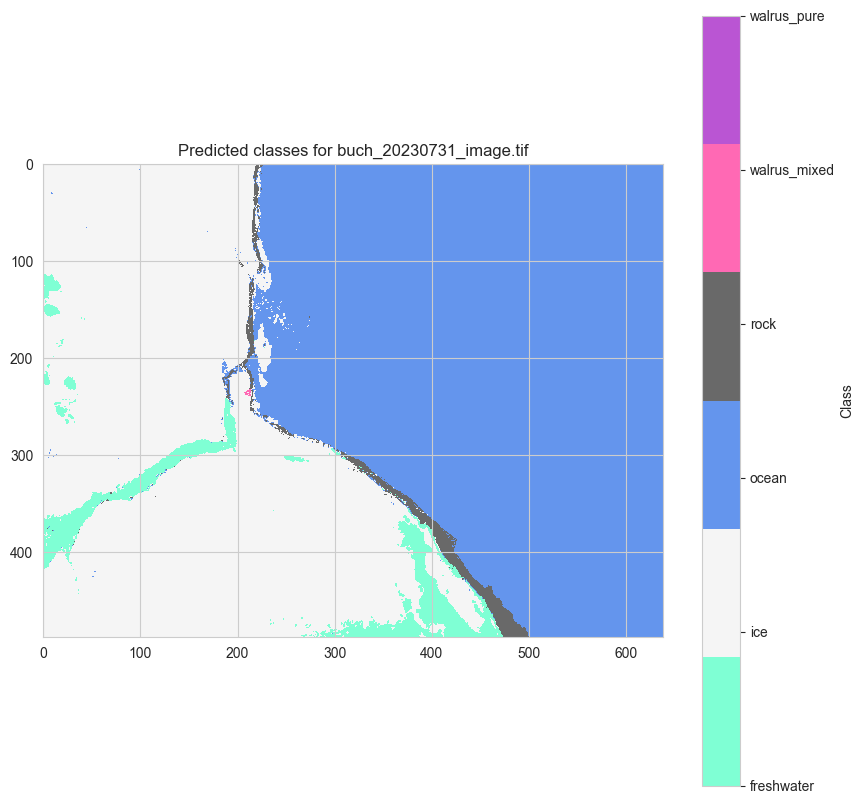

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


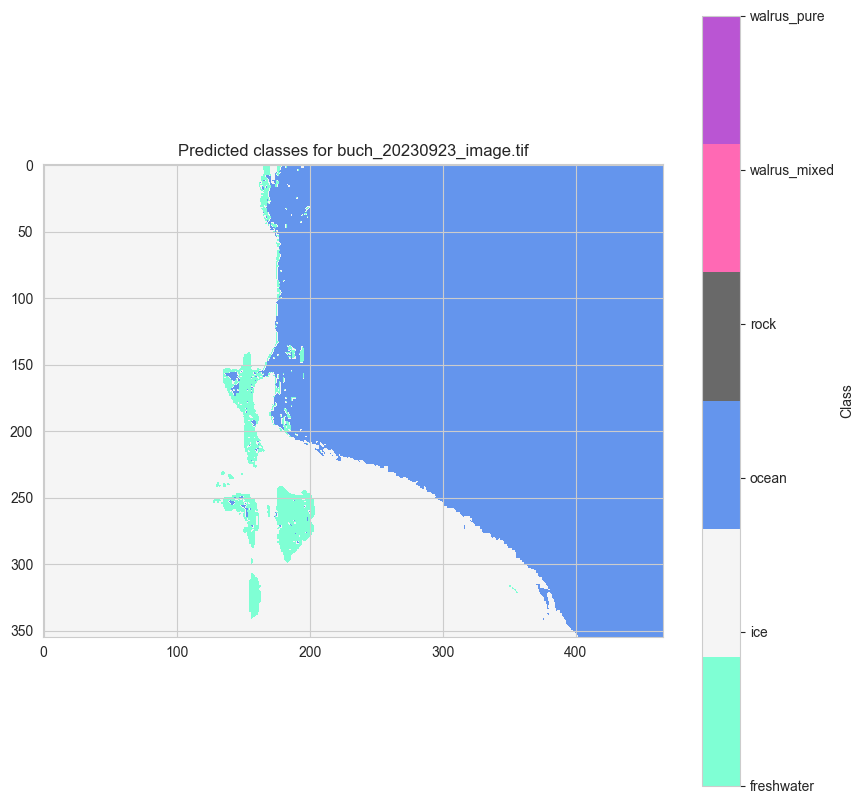

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


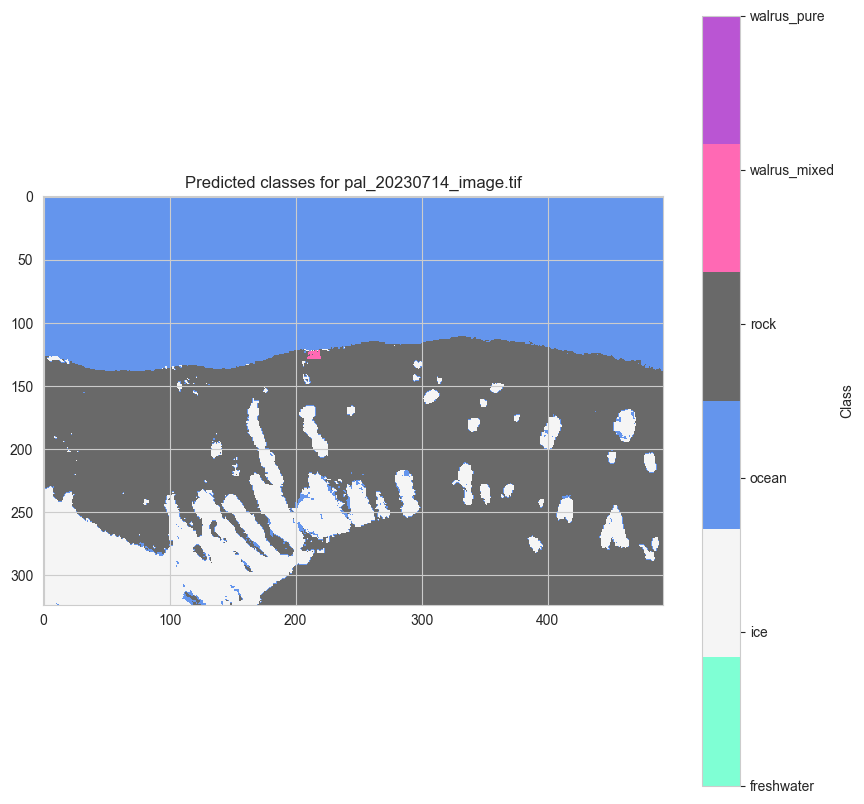

Labels present in pal_20230720_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


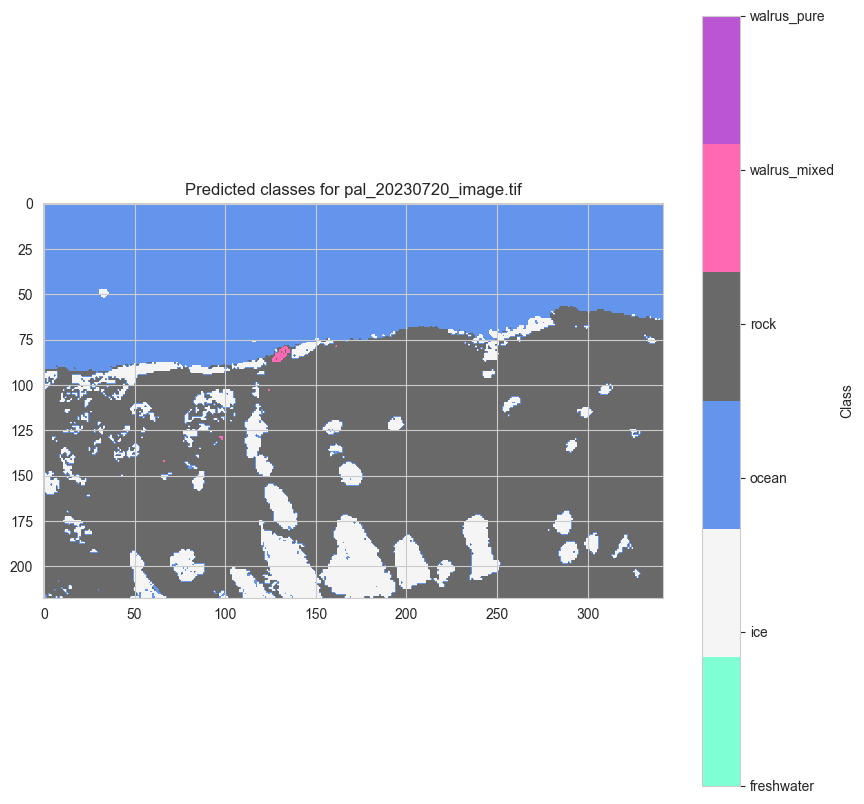

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


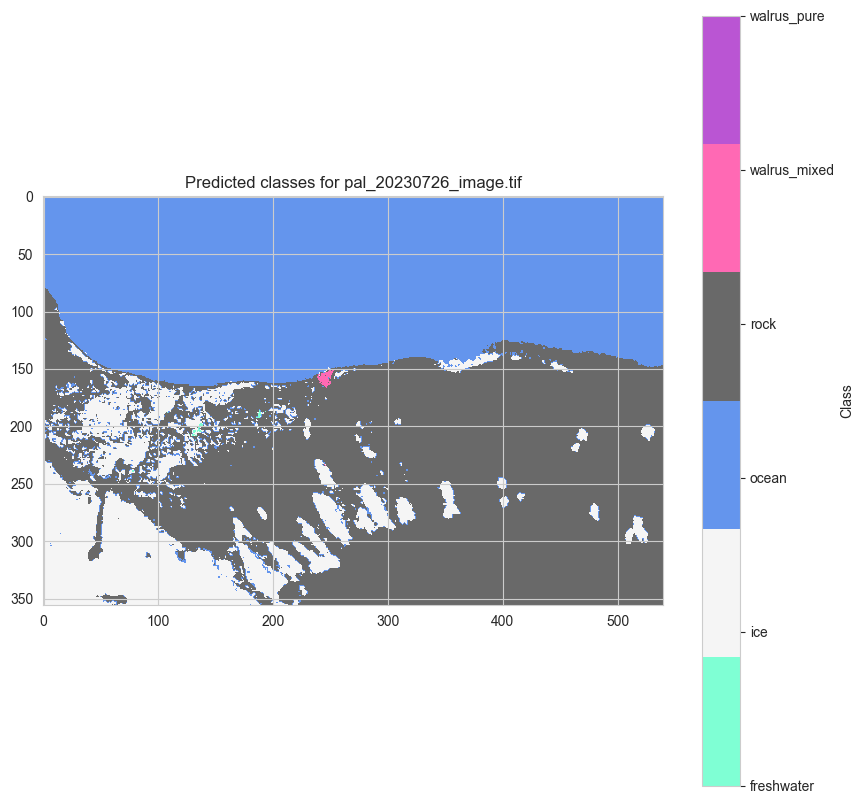

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


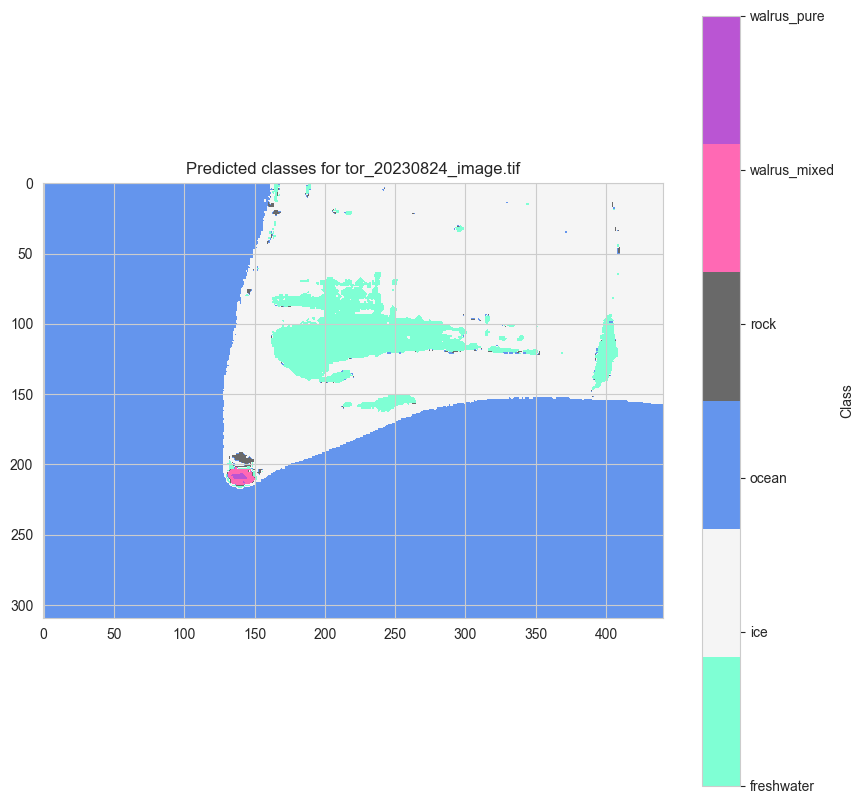

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


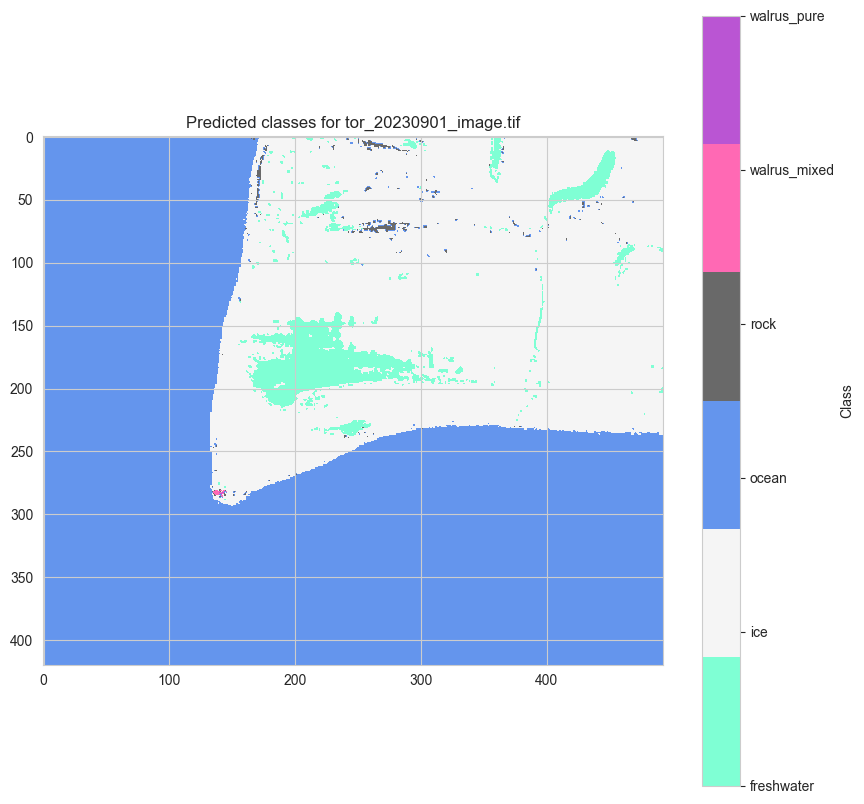

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


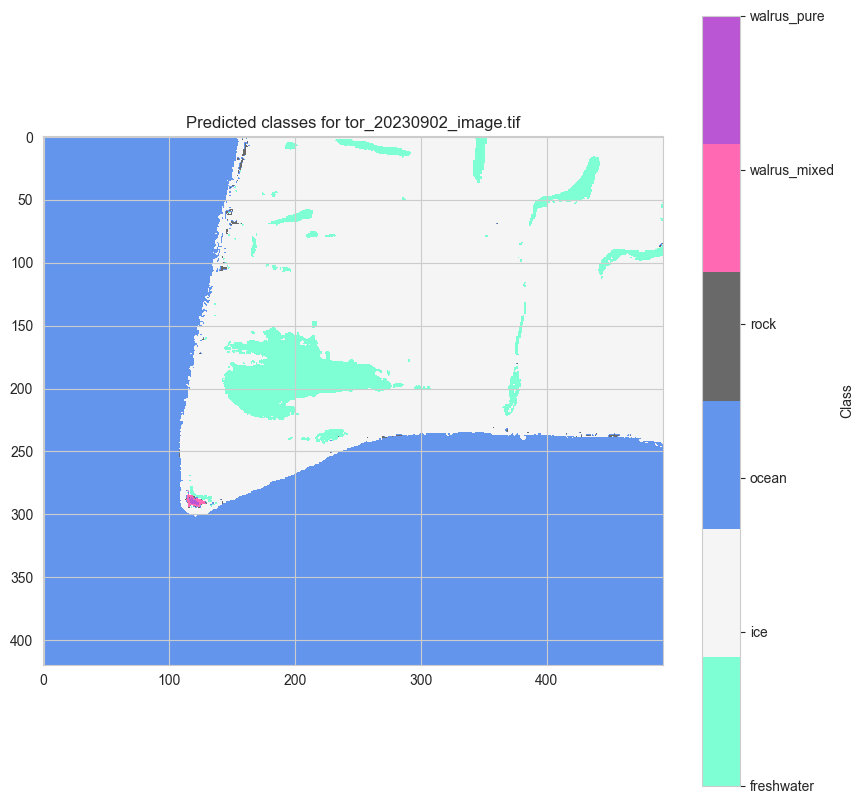

In [6]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)
# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

# Function to plot predictions
def plot_predictions(predicted_images, title):
    for image_path, predicted_image in predicted_images.items():
        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"{title} for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)

        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plt.show()

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fit

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


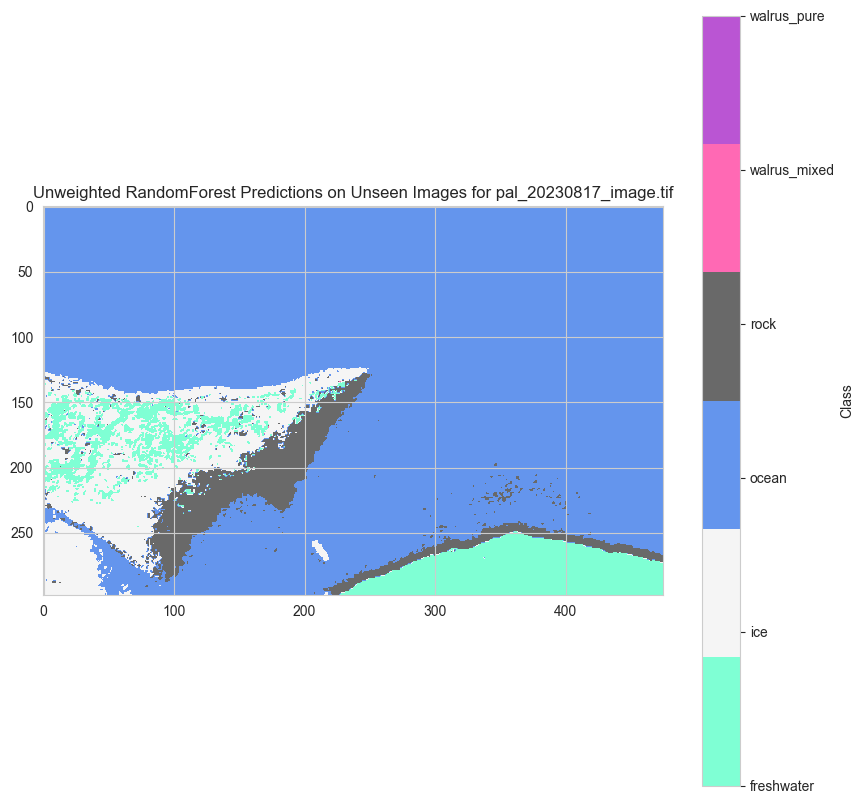

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


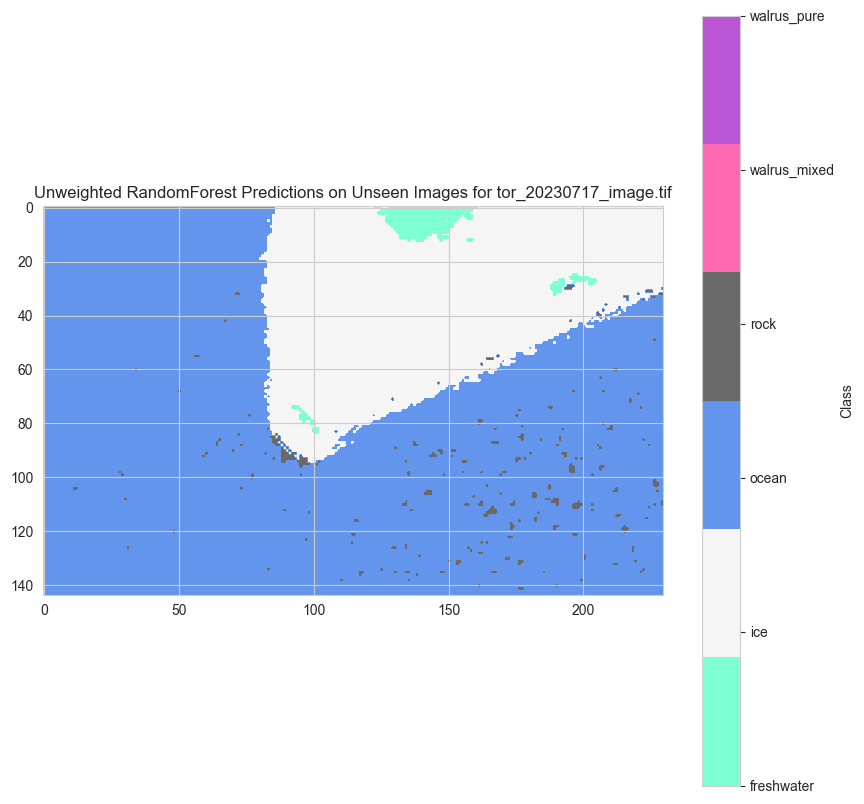

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


In [7]:
# Predict and plot results for unseen images
predicted_images_unseen = {}
for image_path in unlabeled_image_paths:
    predicted_images_unseen[image_path] = predict_image(image_path, model)

plot_predictions(predicted_images_unseen, "Unweighted RandomForest Predictions on Unseen Images")

In [18]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib

In [37]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"  

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

In [38]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [39]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [40]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\moff_20230717_train.shp
Image: C:\Users\Student\D

In [41]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
# Save the model
model_filename = "walrus_model_allislands.joblib"
joblib.dump(model, model_filename)


['walrus_model_allislands.joblib']

In [43]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      8044
         ice       0.98      0.99      0.98     60098
       ocean       1.00      1.00      1.00    155893
        rock       0.98      0.97      0.97     18474
walrus_mixed       1.00      0.28      0.44       178
 walrus_pure       0.86      0.92      0.89        13

    accuracy                           0.99    242700
   macro avg       0.95      0.84      0.86    242700
weighted avg       0.99      0.99      0.99    242700


In [44]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


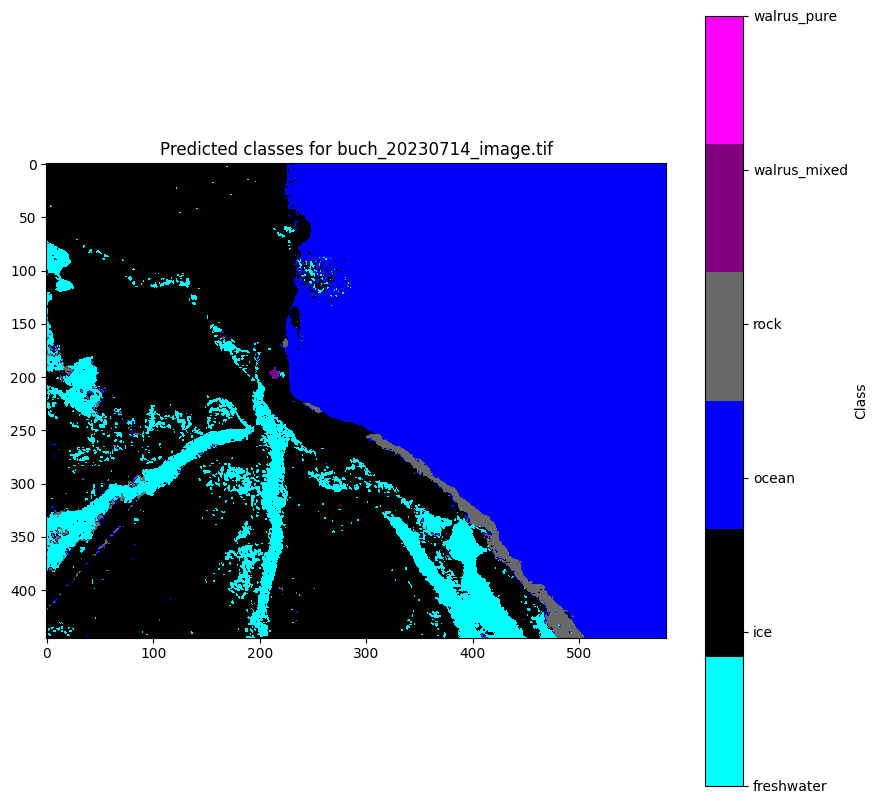

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


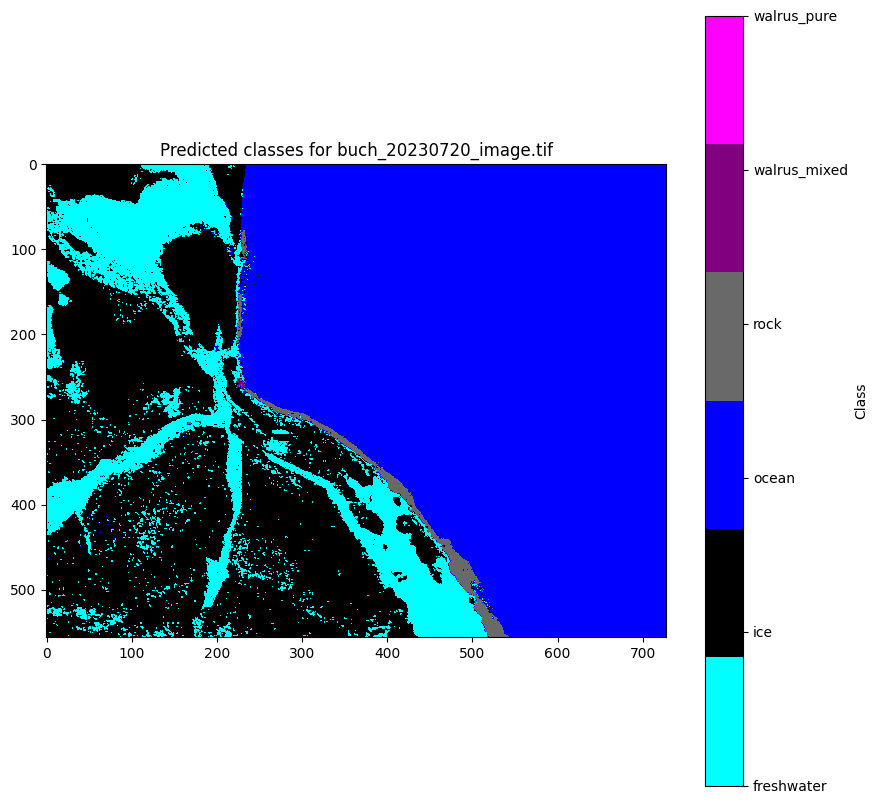

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


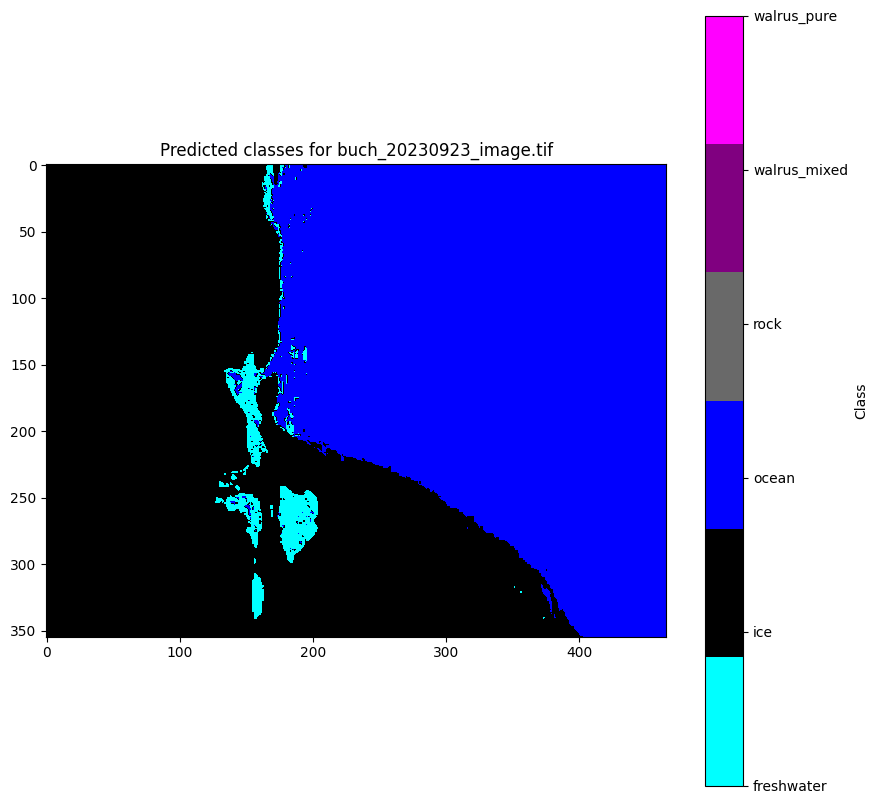

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


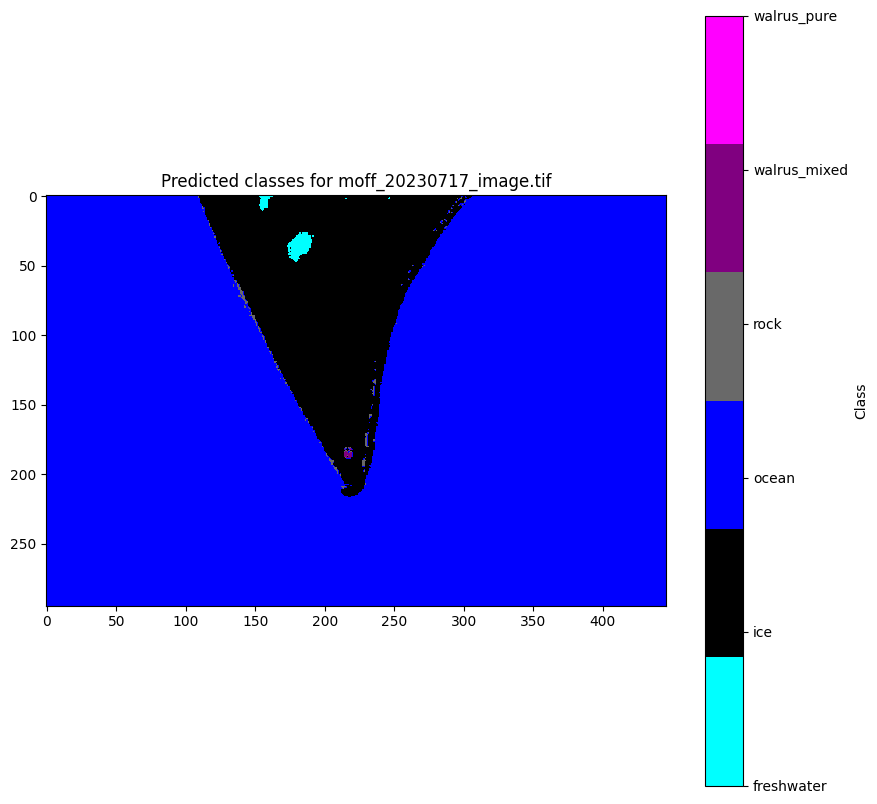

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


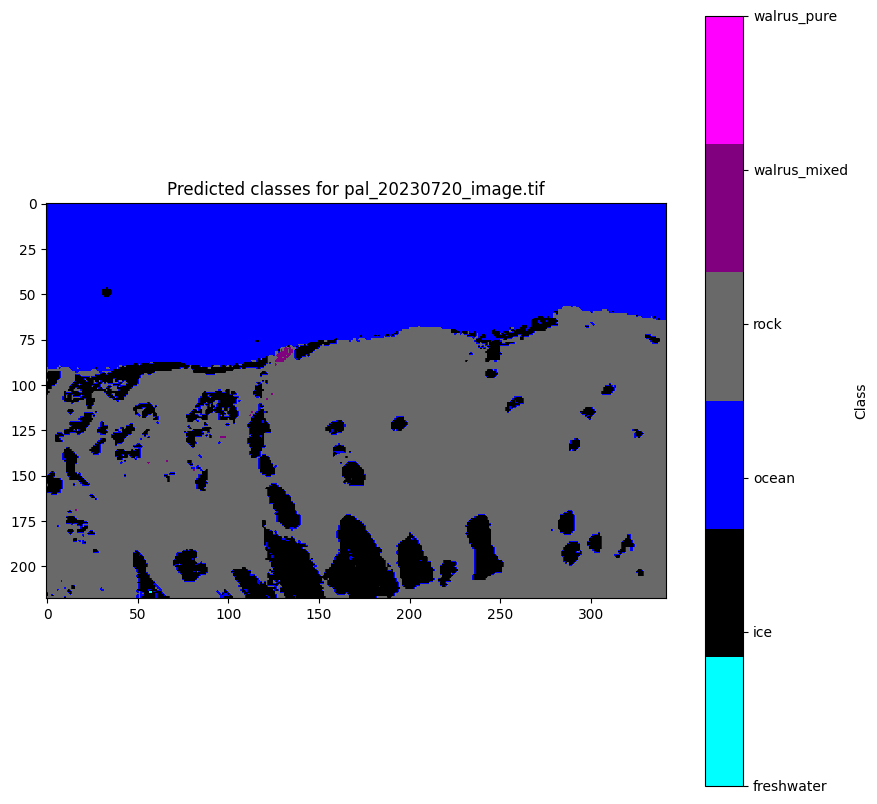

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


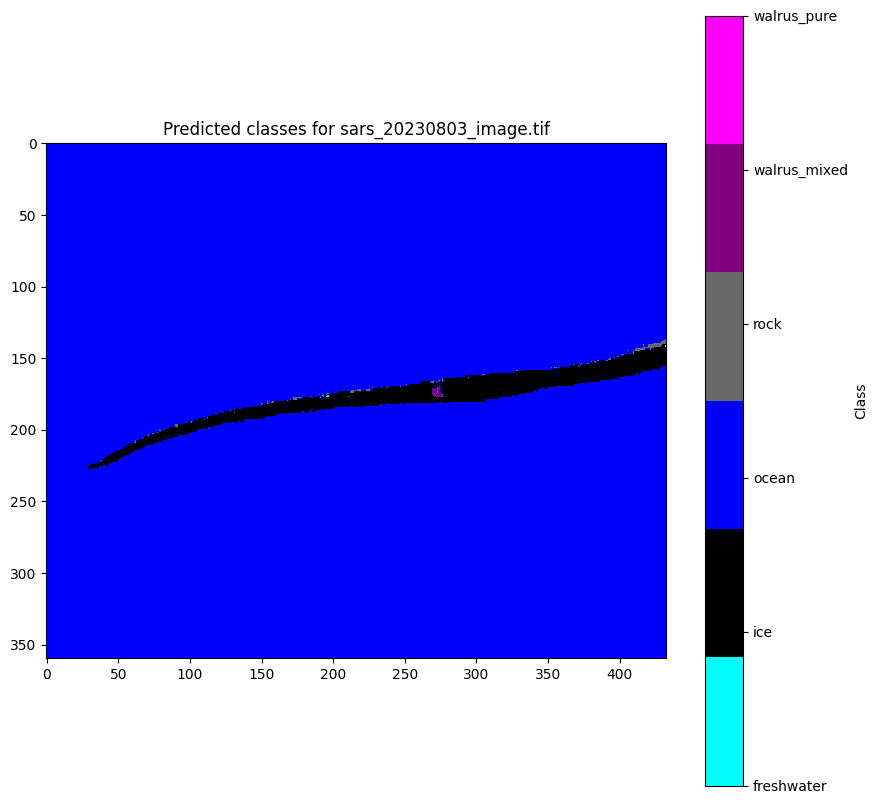

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


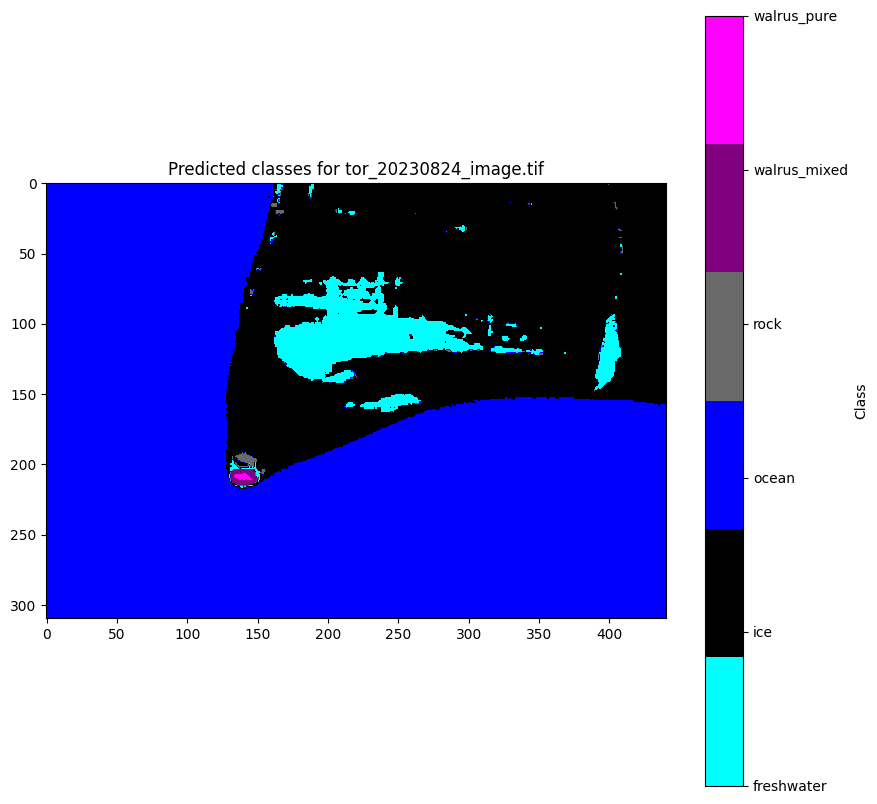

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


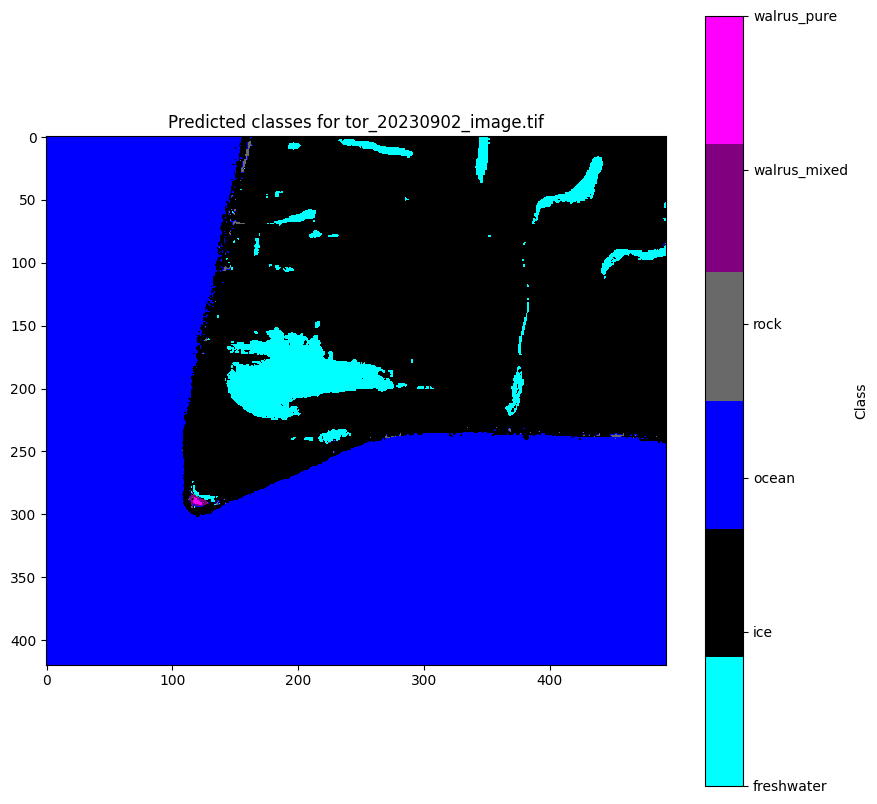

In [45]:
# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [46]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")


Model loaded from walrus_model_allislands.joblib


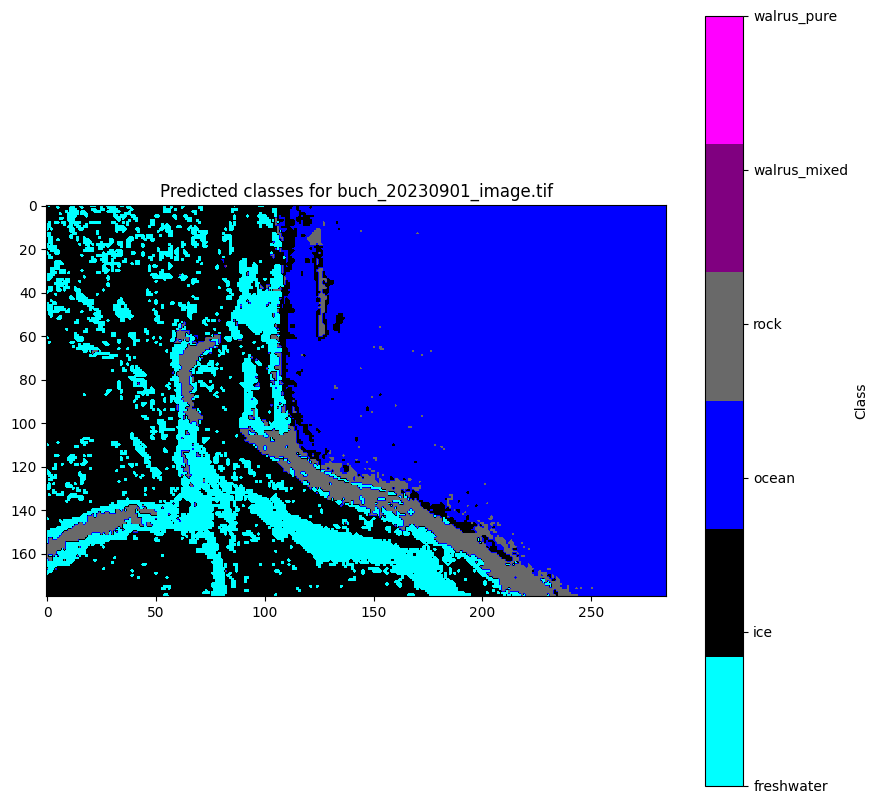

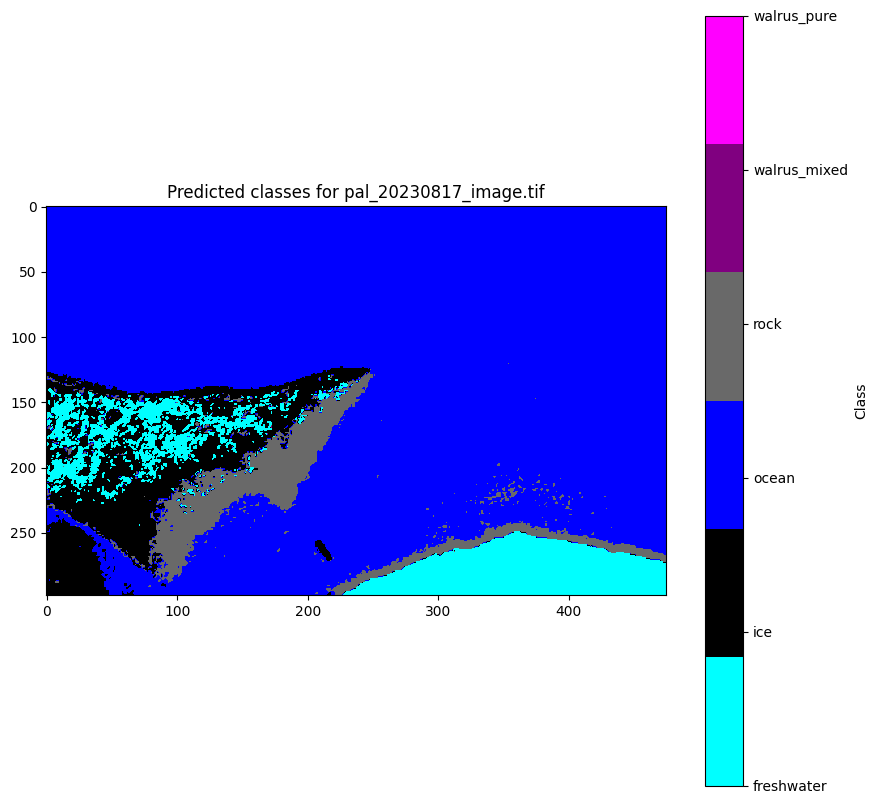

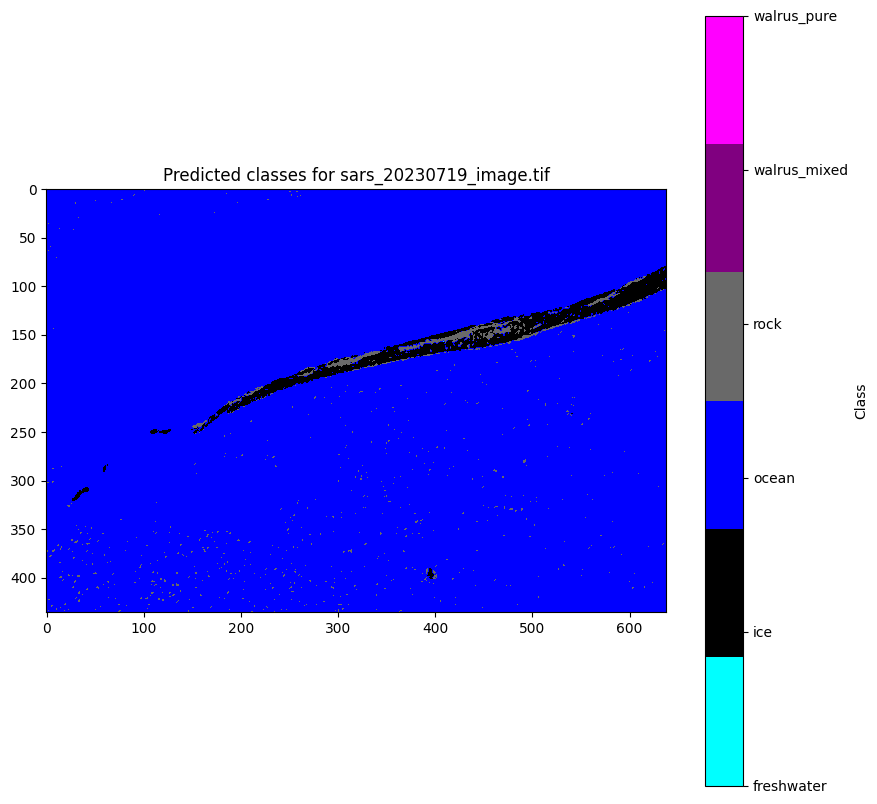

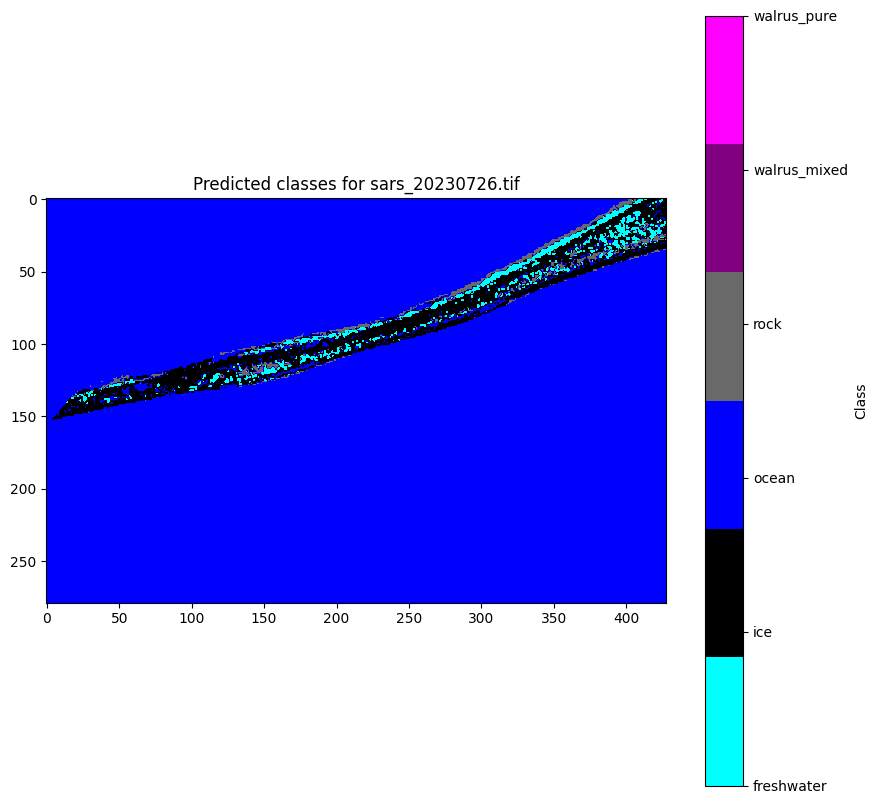

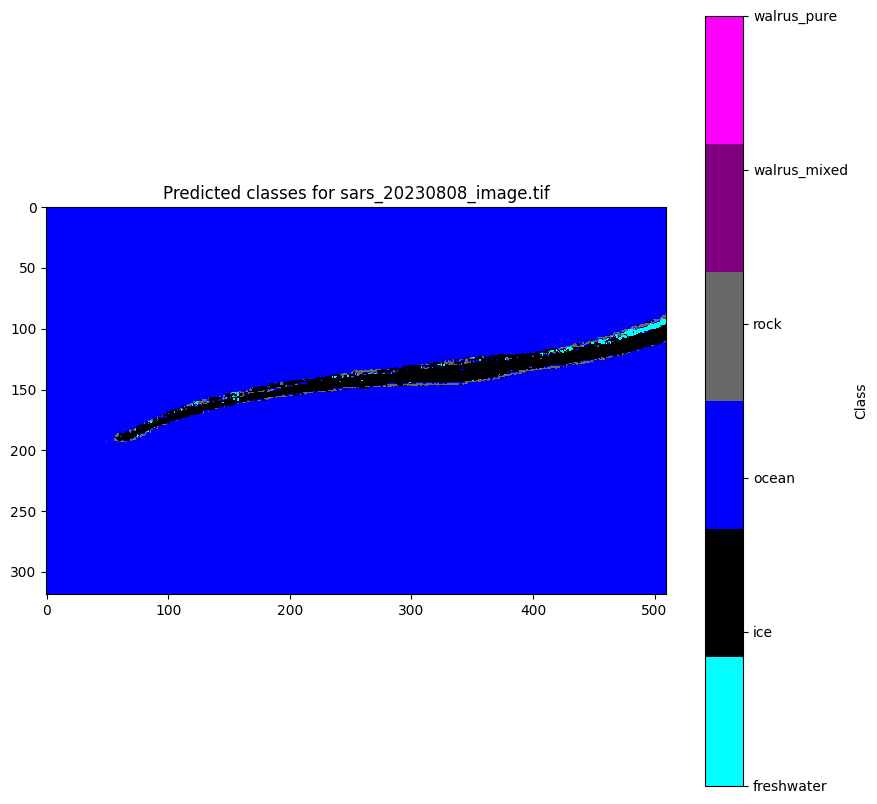

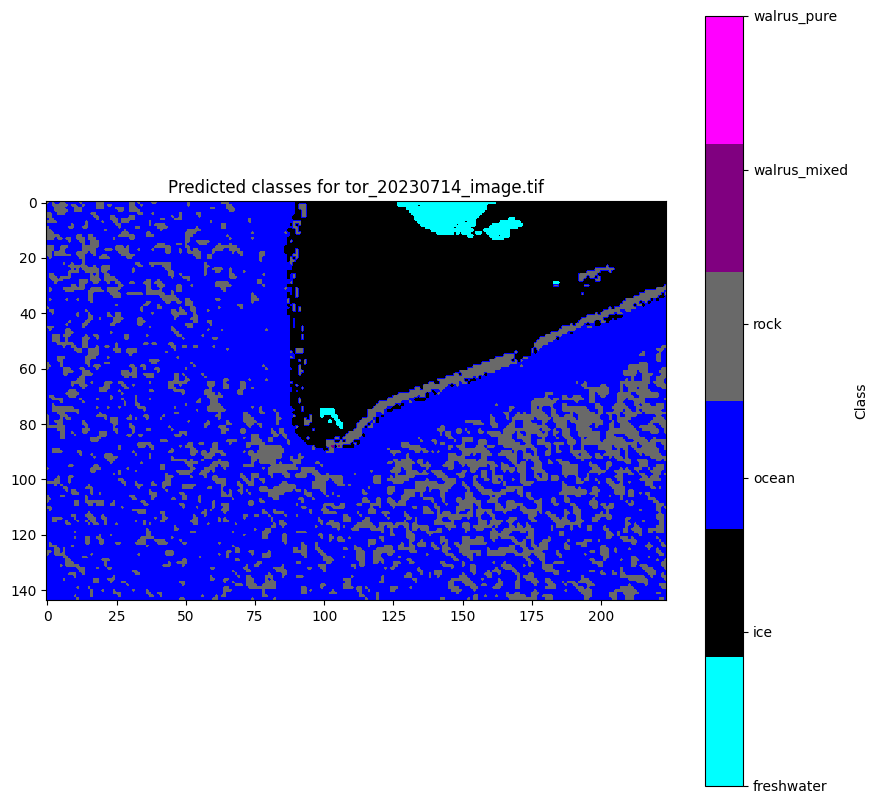

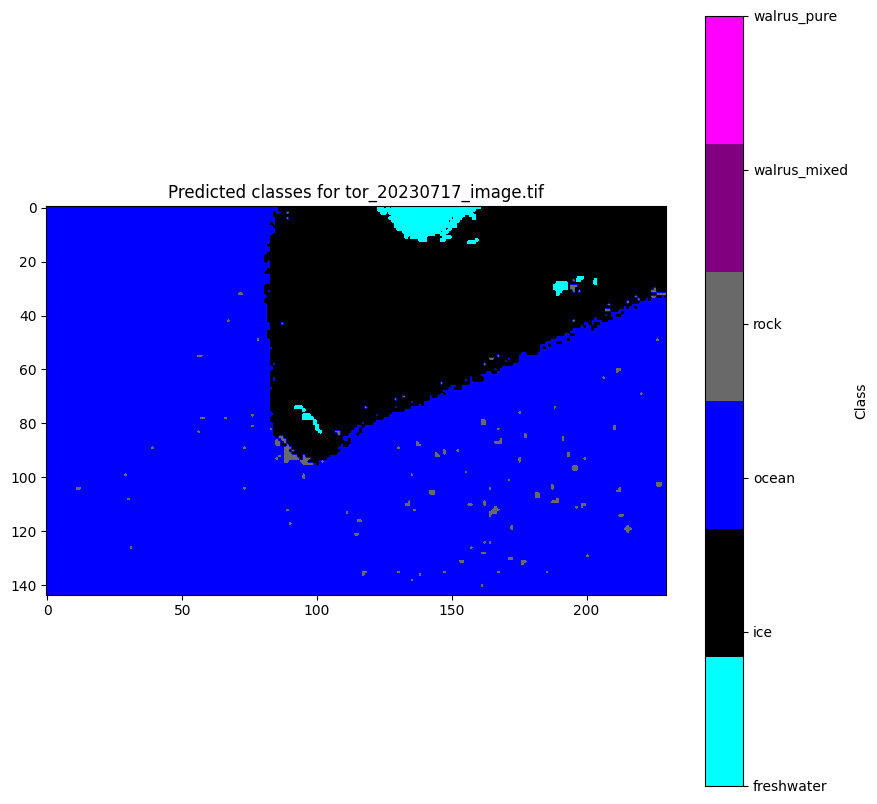

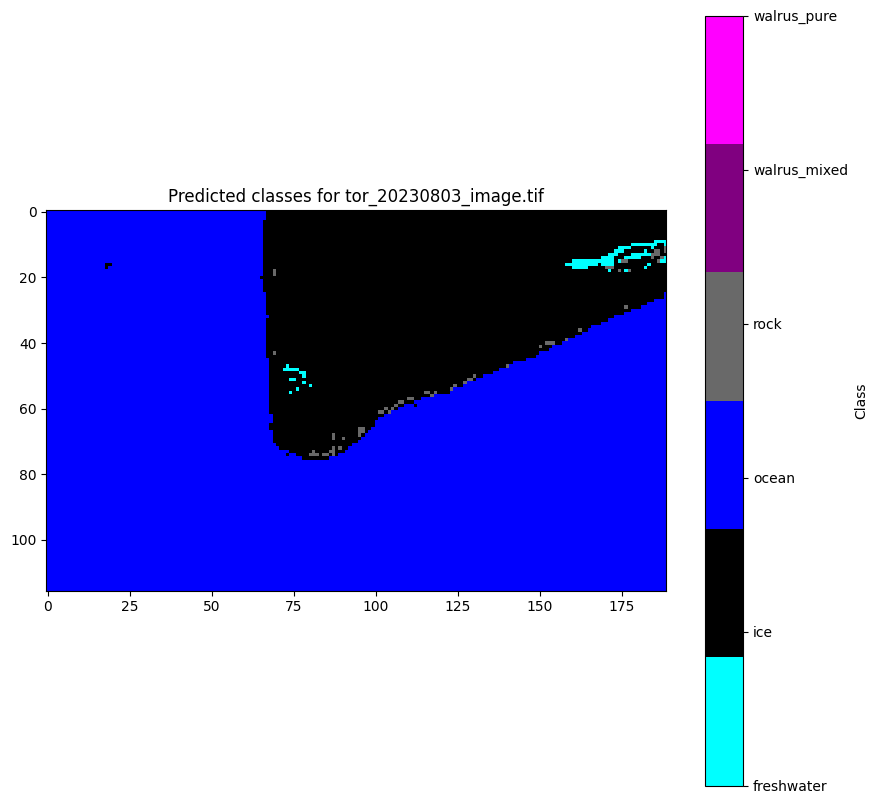

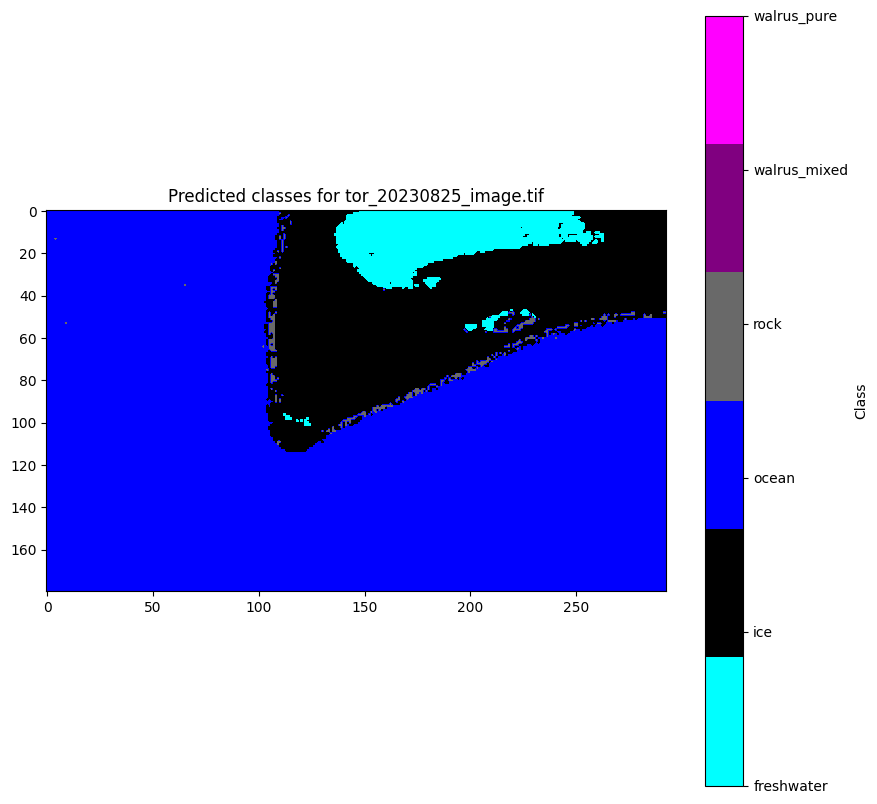

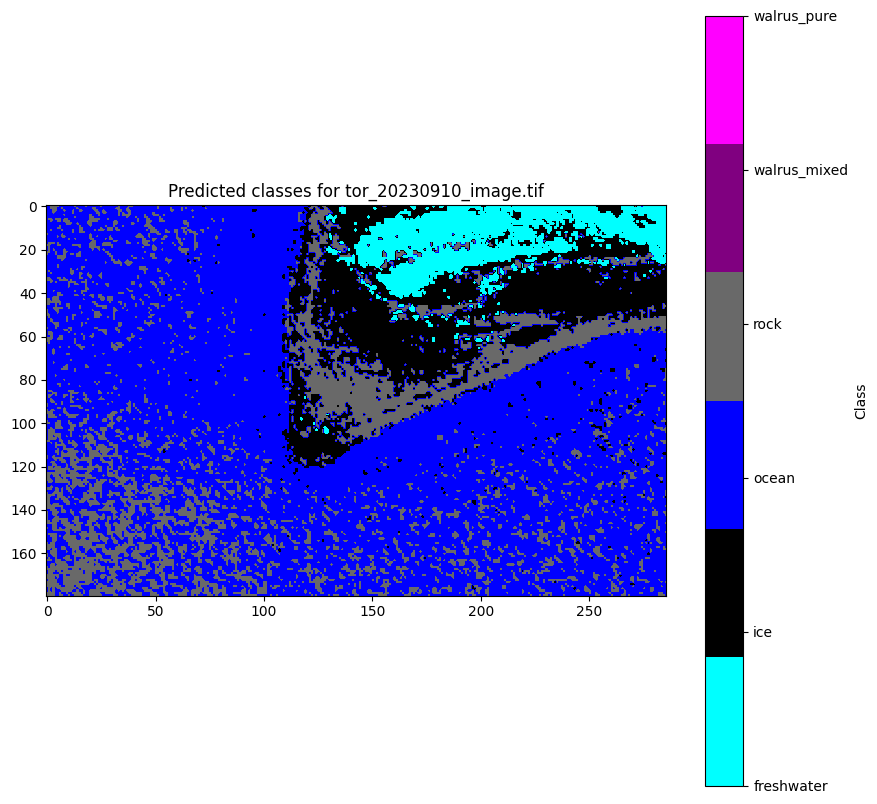

In [47]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


In [48]:
# Additional print statements to verify that the image is being predicted and plotted
def predict_image(image_path, model):
    print(f"Predicting classes for {image_path}...")
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        print(f"Predictions shape: {predictions.shape}")
        return predictions.reshape((src.height, src.width))

In [29]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)

for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

In [33]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    print(f"Predicting classes for {image_path}...")
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))


In [31]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

# Function to plot predicted images
def plot_predicted_image(image_path, predicted_image):
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

In [32]:

# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)

# Plot the predicted images
for image_path in unlabeled_image_paths:
    print(f"Processing {image_path}...")
    predicted_image = predict_image(image_path, loaded_model)
    
    if predicted_image is not None and predicted_image.size > 0:
        plot_predicted_image(image_path, predicted_image)
    else:
        print(f"Failed to predict or empty prediction for {image_path}")

In [5]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\moff_20230717_train.shp
Image: C:\Users\Student\D

In [6]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

dont run this 

In [ ]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [7]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
# Save the trained model and label encoder with the specified name
joblib.dump(model, 'walrus_randomforest_allislands.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [10]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      8044
         ice       0.98      0.99      0.98     60098
       ocean       1.00      1.00      1.00    155893
        rock       0.98      0.97      0.97     18474
walrus_mixed       1.00      0.28      0.44       178
 walrus_pure       0.86      0.92      0.89        13

    accuracy                           0.99    242700
   macro avg       0.95      0.84      0.86    242700
weighted avg       0.99      0.99      0.99    242700


In [11]:
def predict_image(image_path, model, le):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))


In [12]:
# Load the trained model and label encoder
model = joblib.load('walrus_randomforest_allislands.pkl')
le = joblib.load('label_encoder.pkl')

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model, le)


In [13]:
# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])


Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\buch_20230714_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\buch_20230720_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\buch_20230731_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\buch_20230923_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\moff_20230717_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\pal_20230714_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groundtruth\pal_20230720_groundtruth.tiff
Ground truth image not found: C:\Users\Student\Documents\101_walrus_data\train\clipped_groun

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


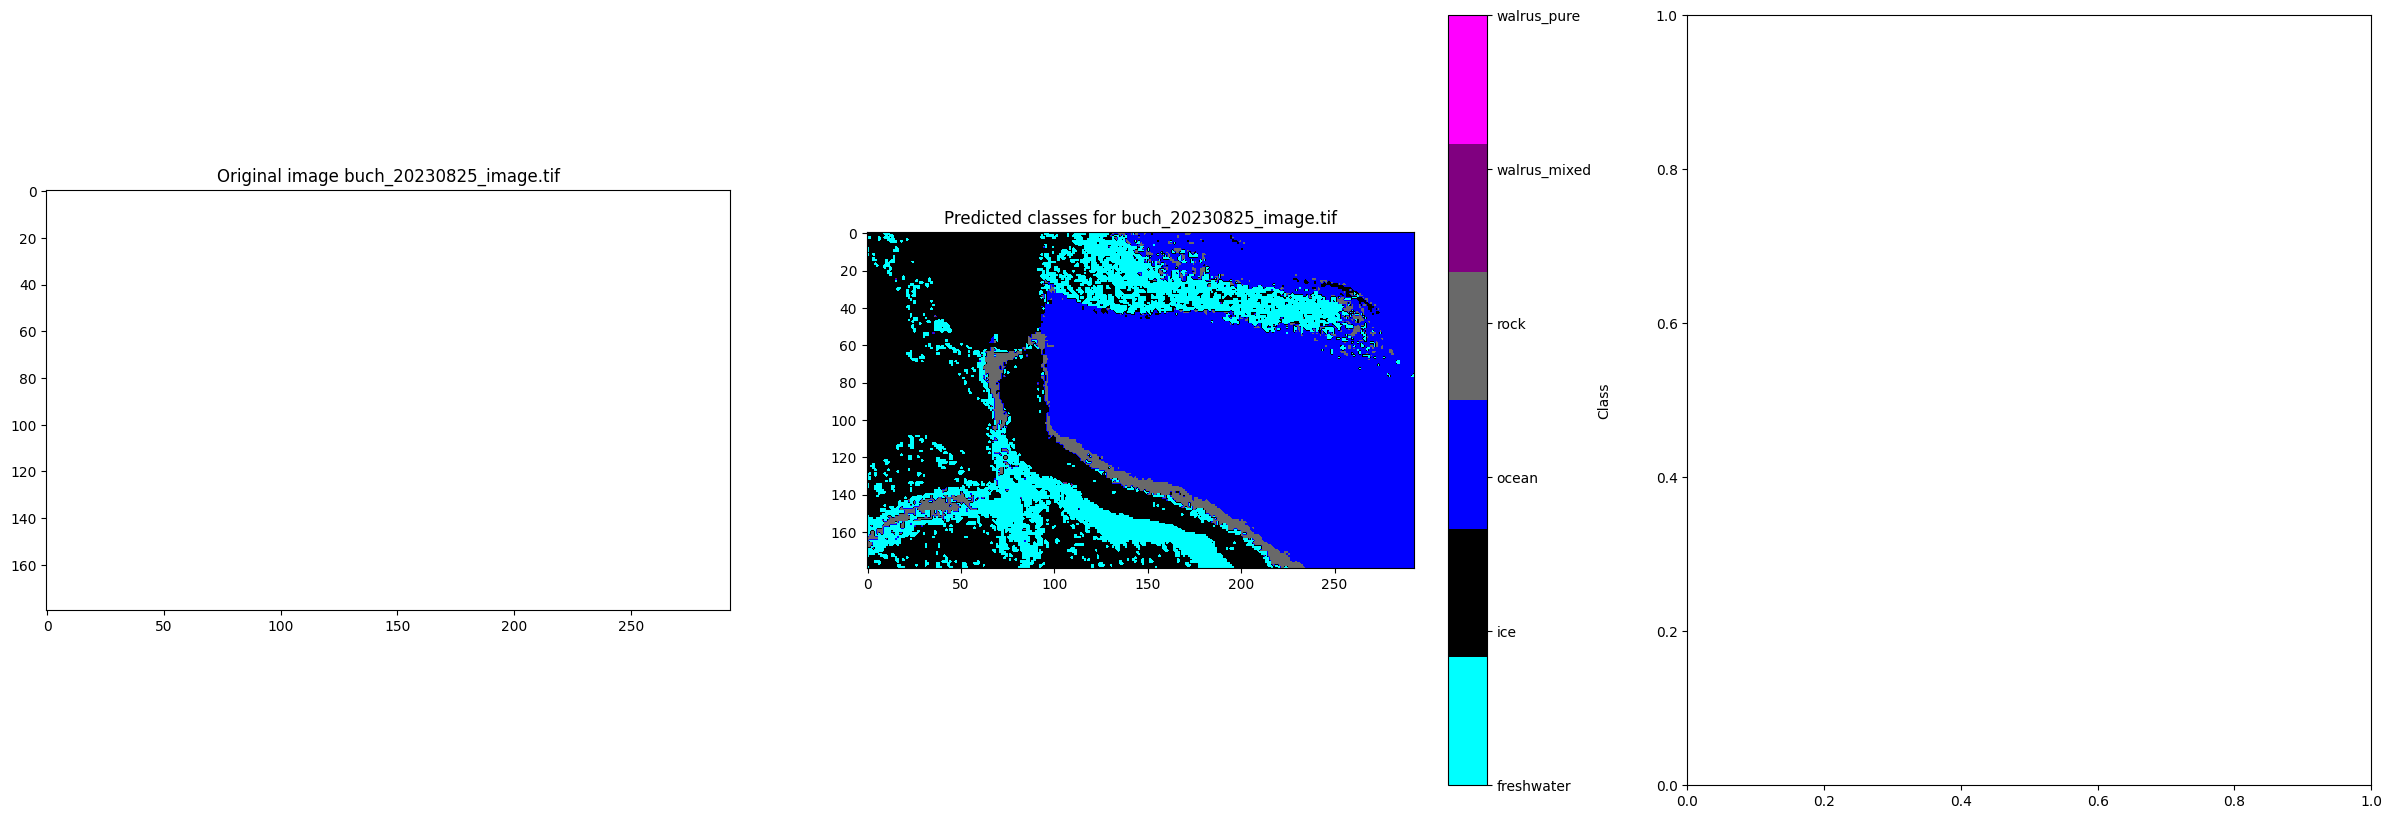

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


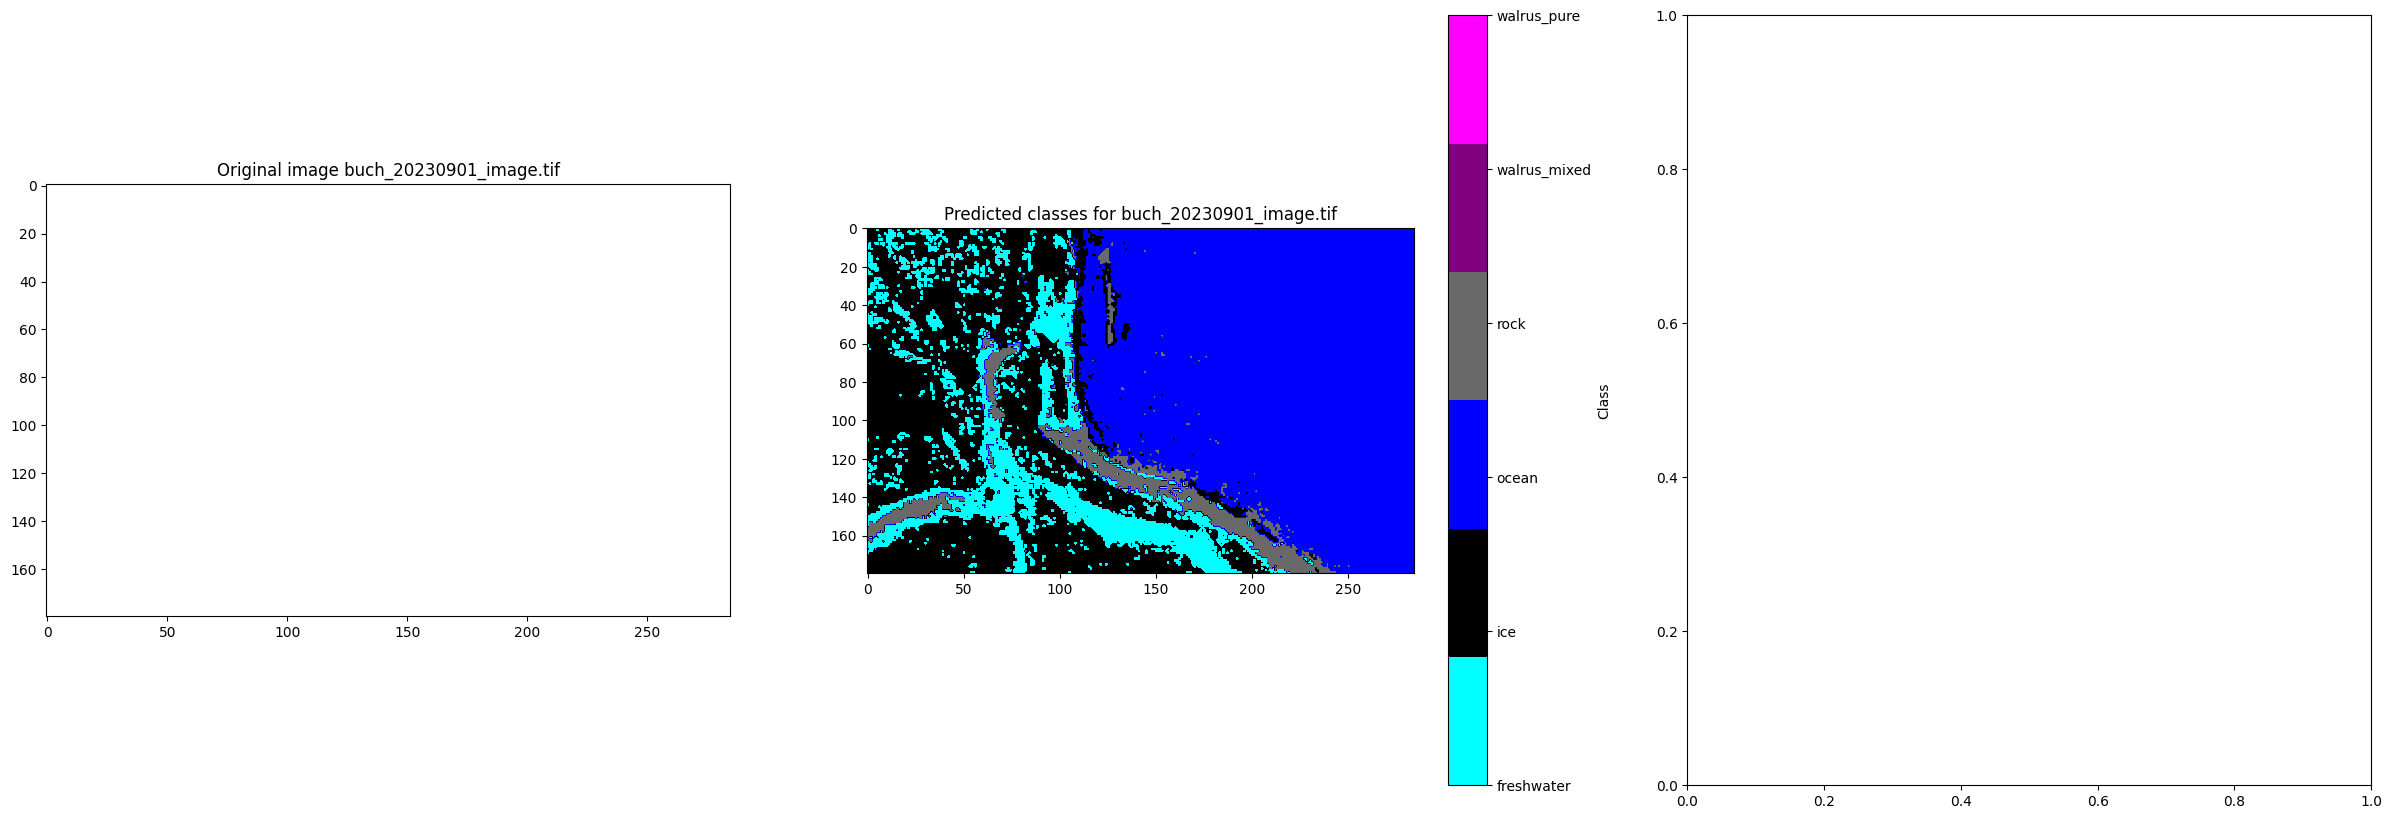

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


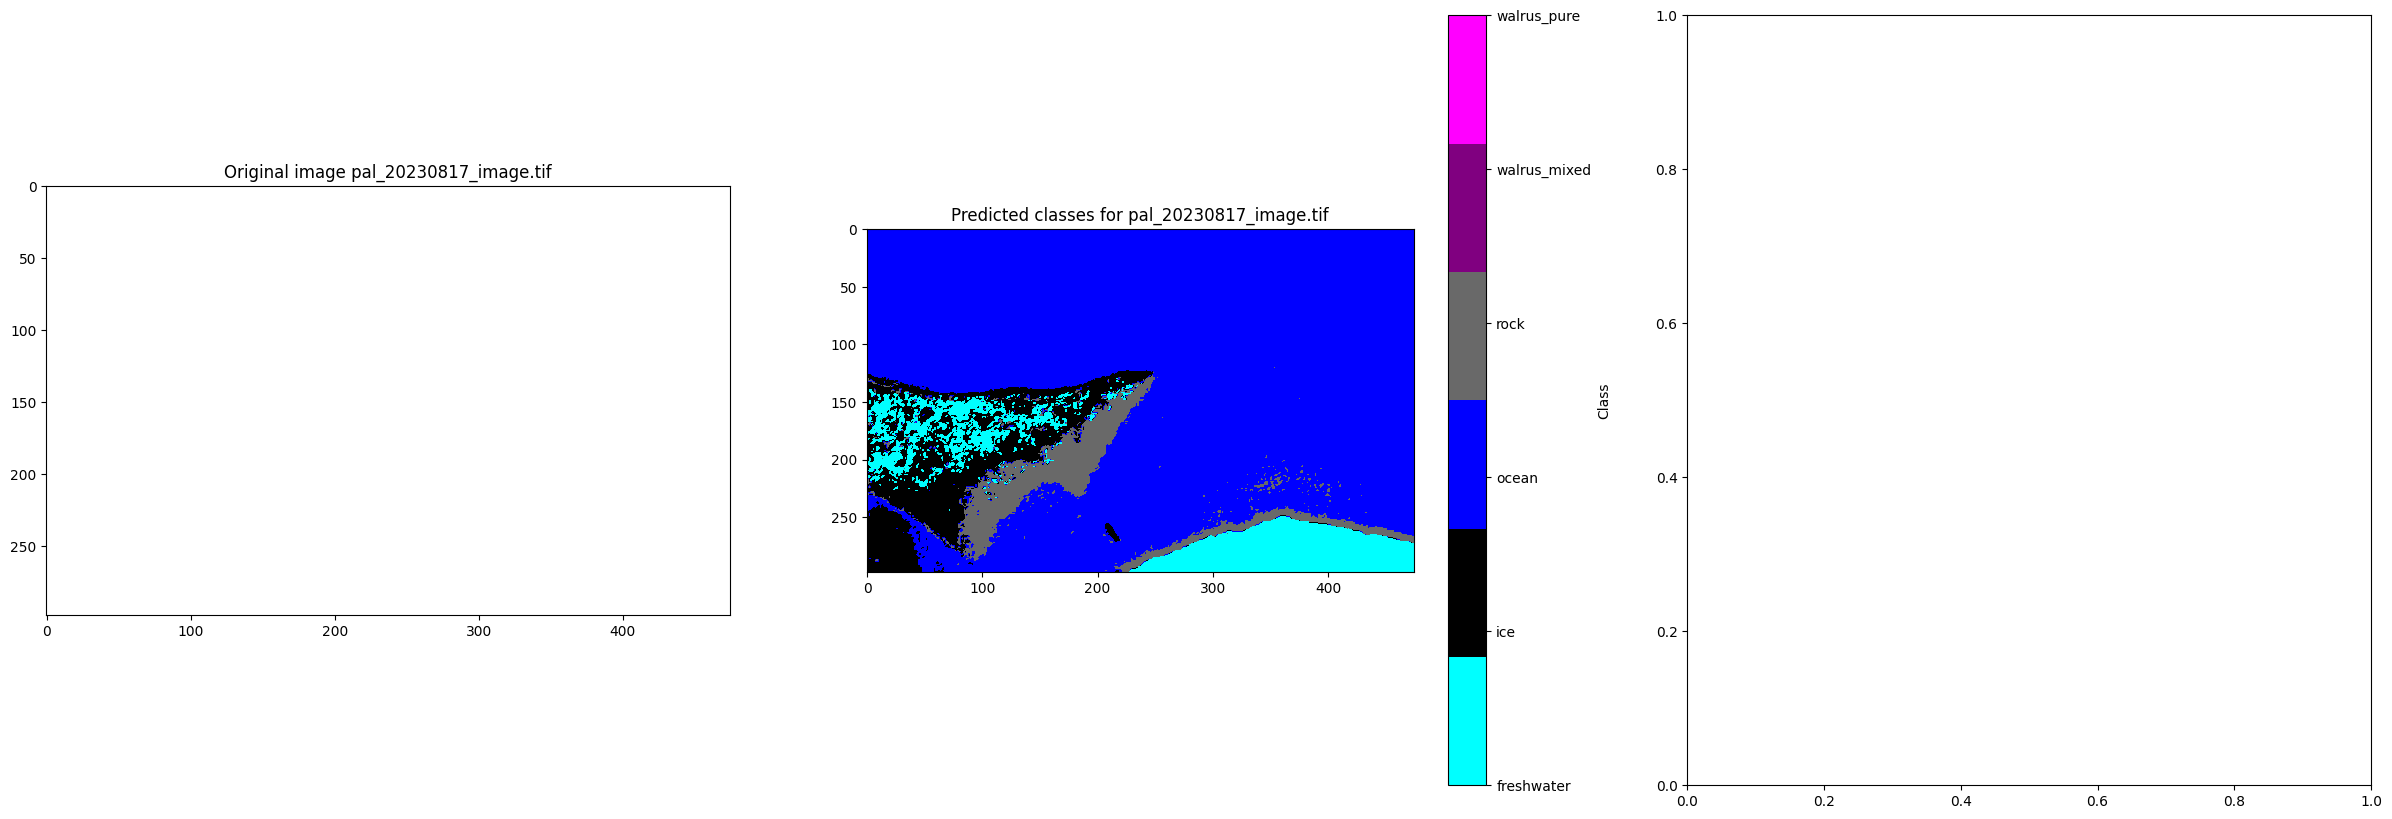

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


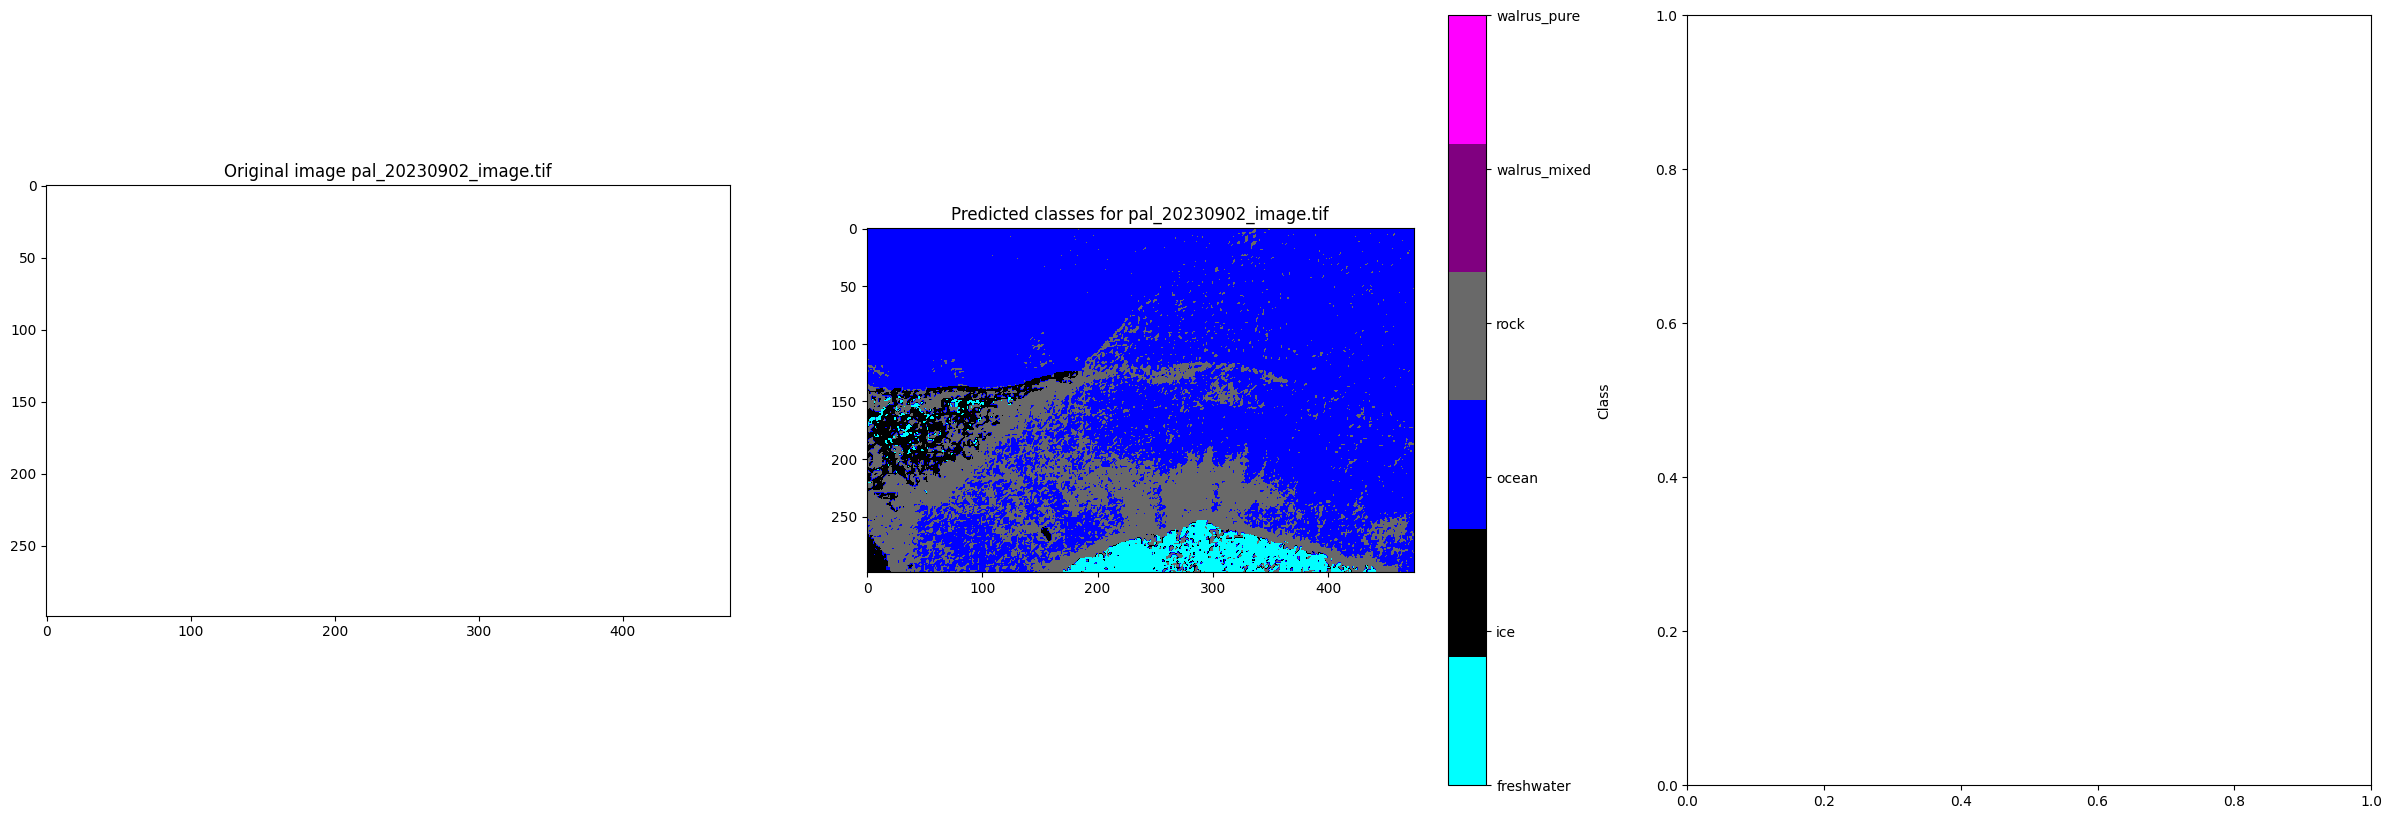

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


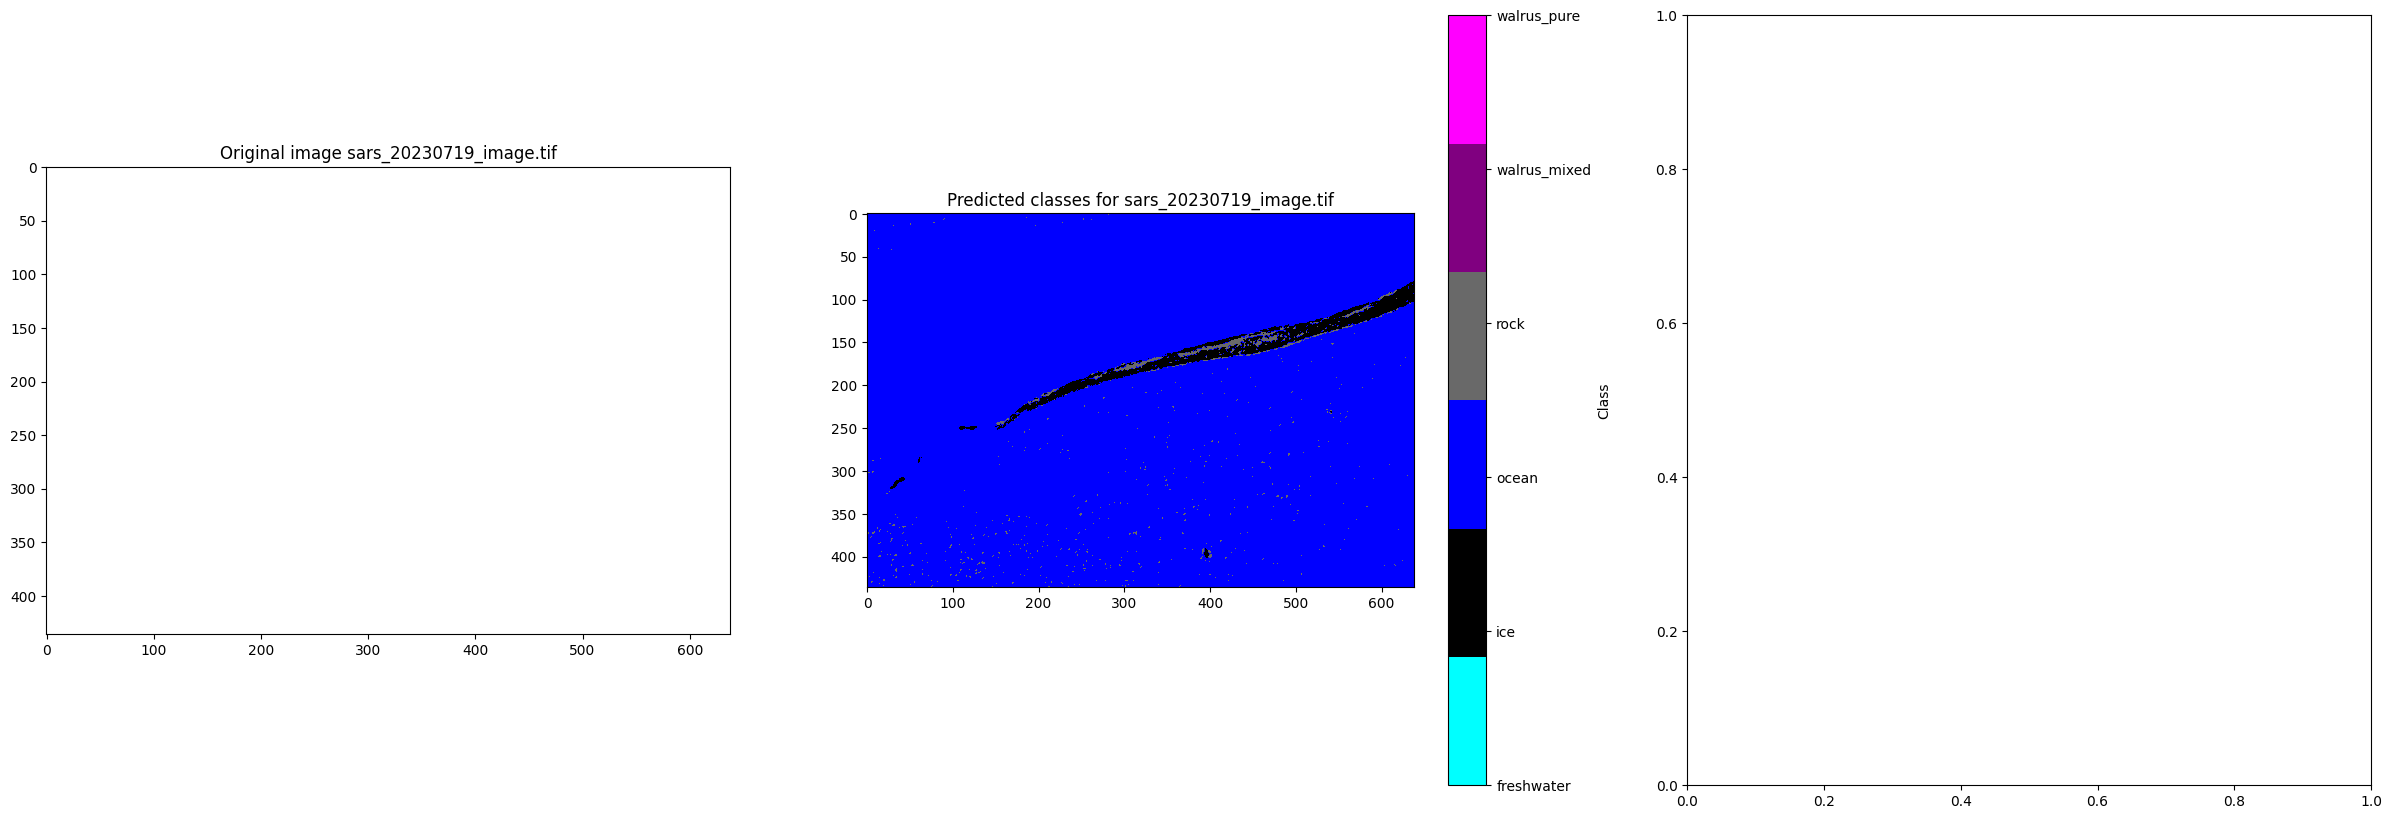

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


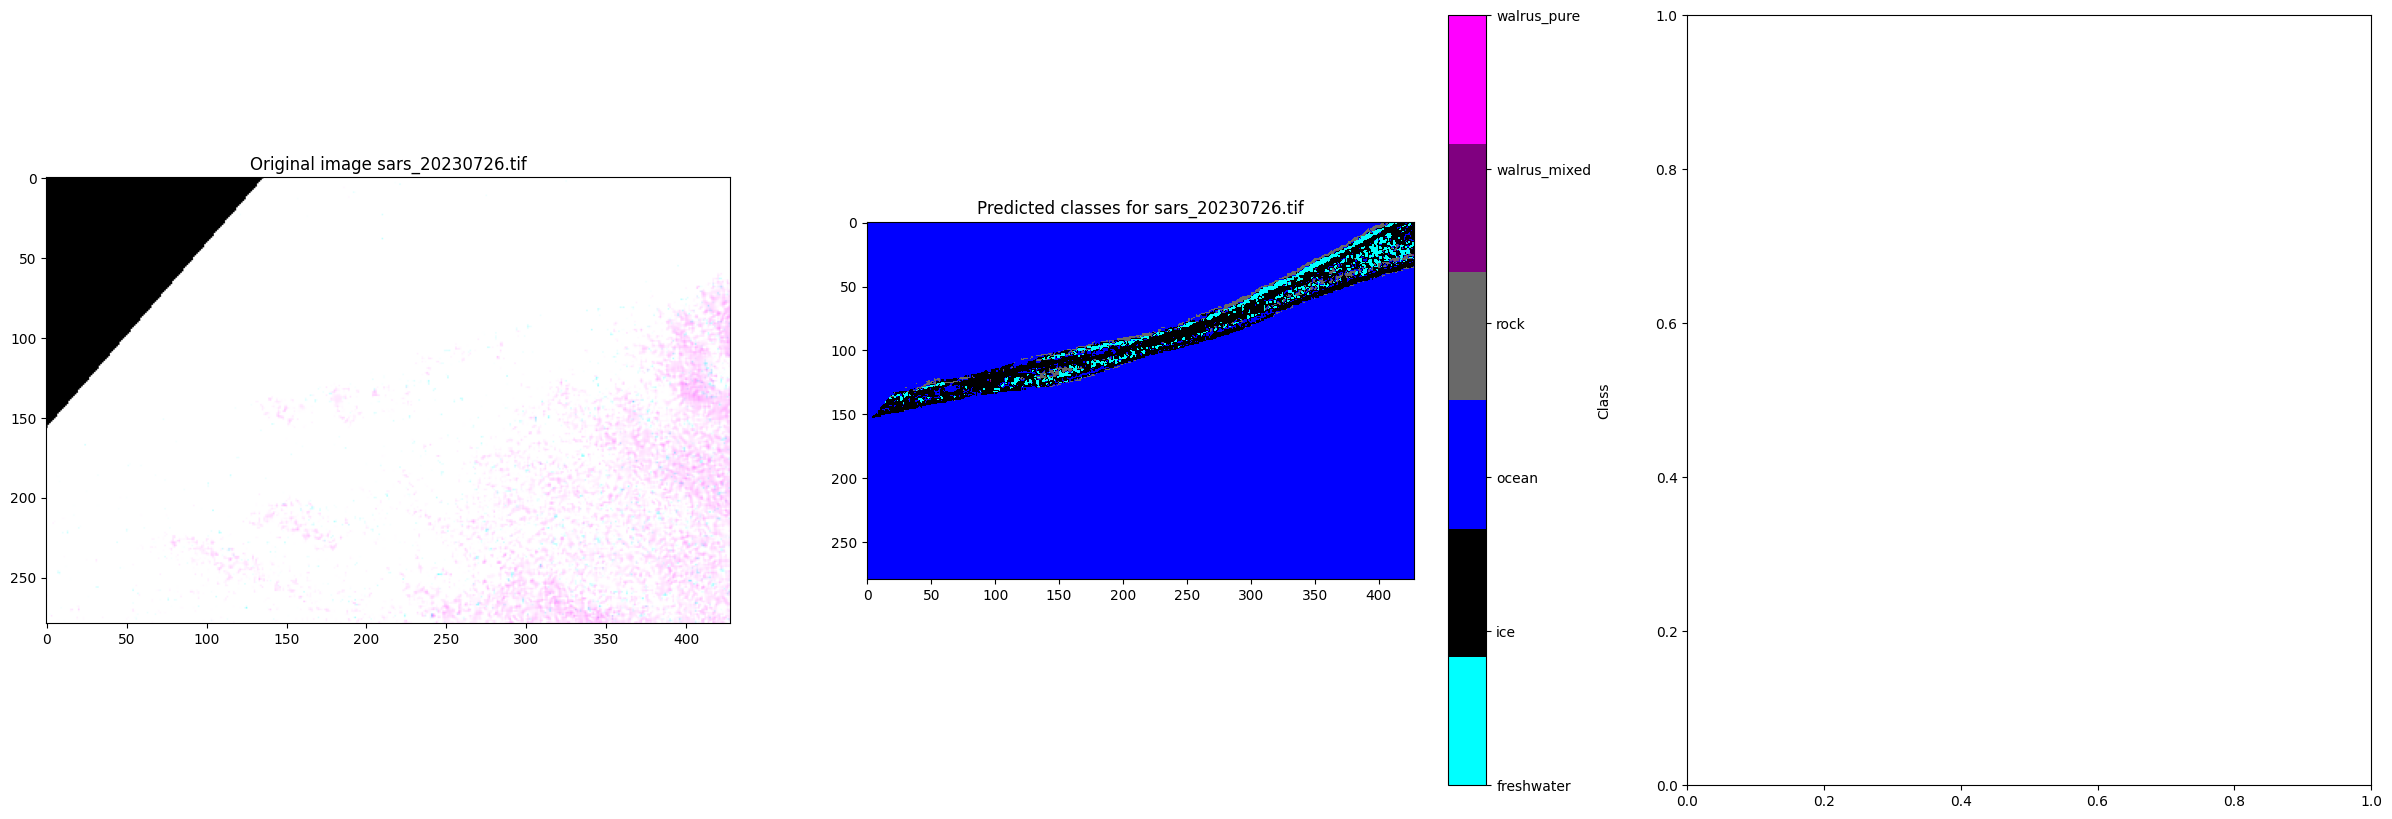

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


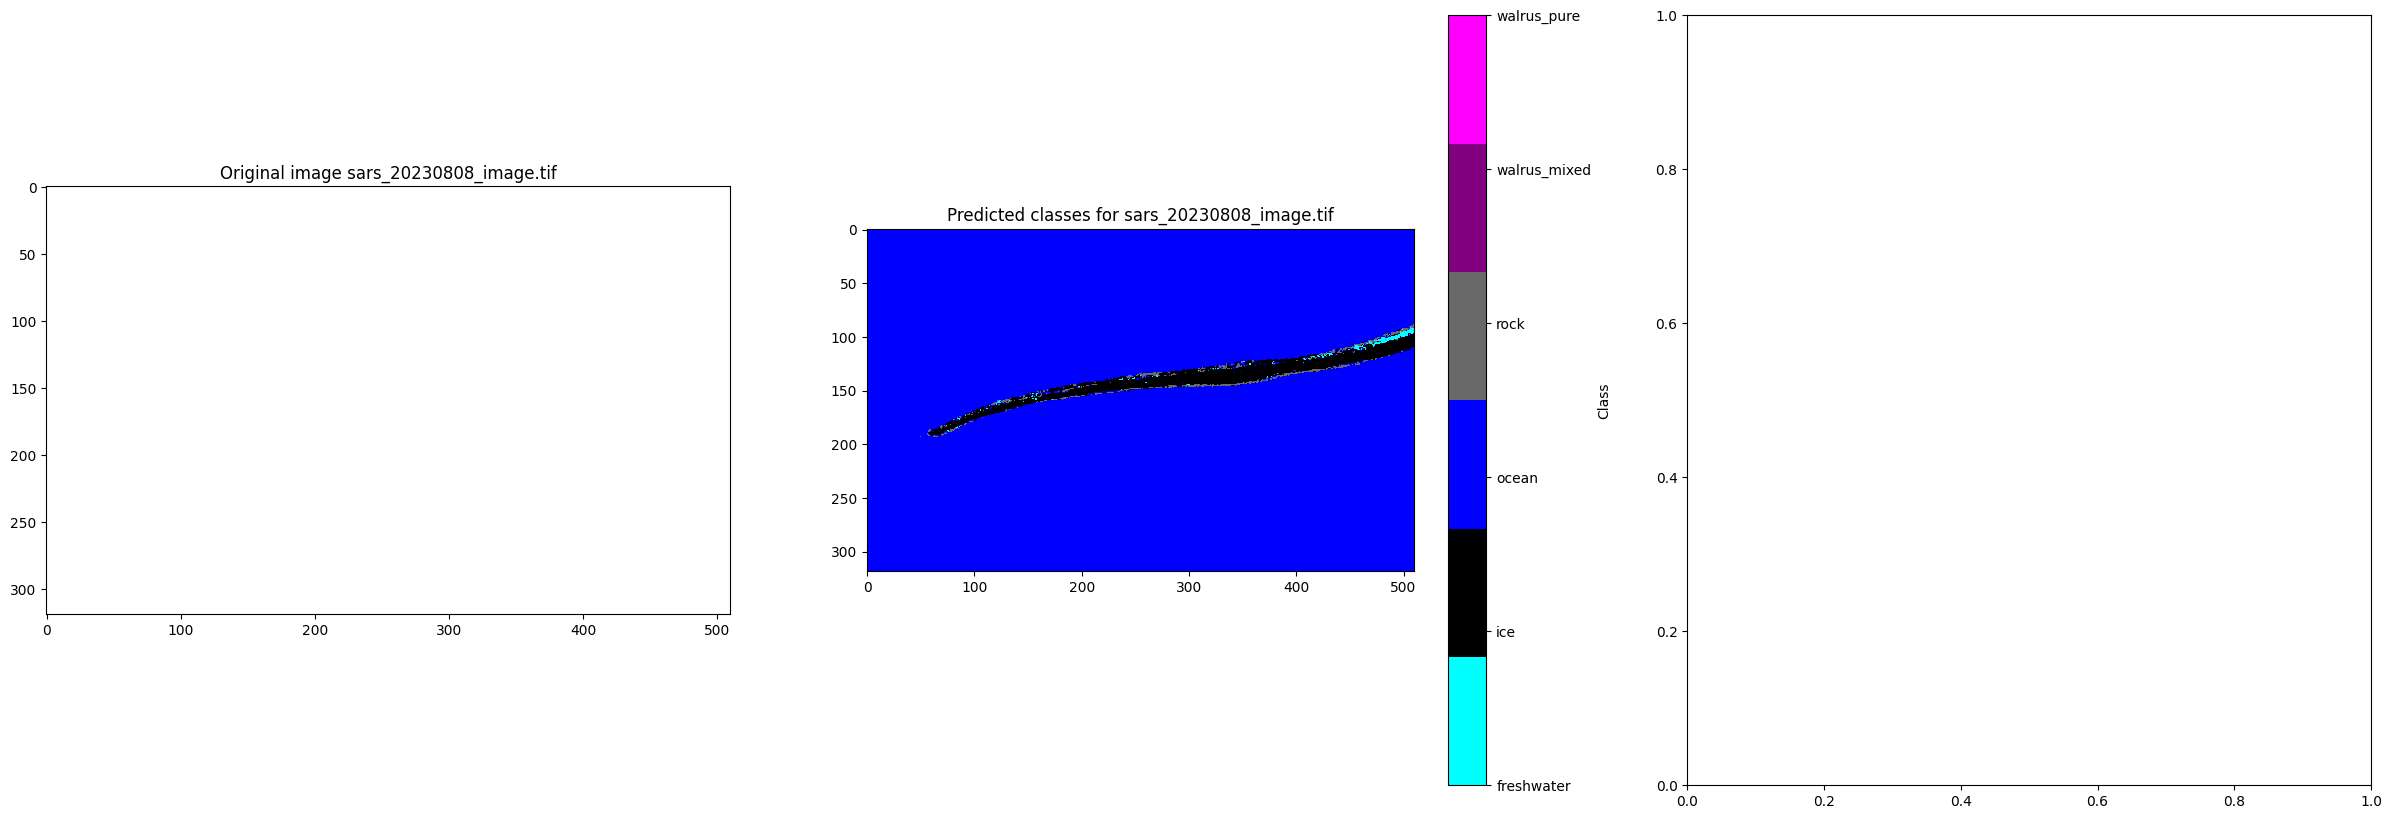

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


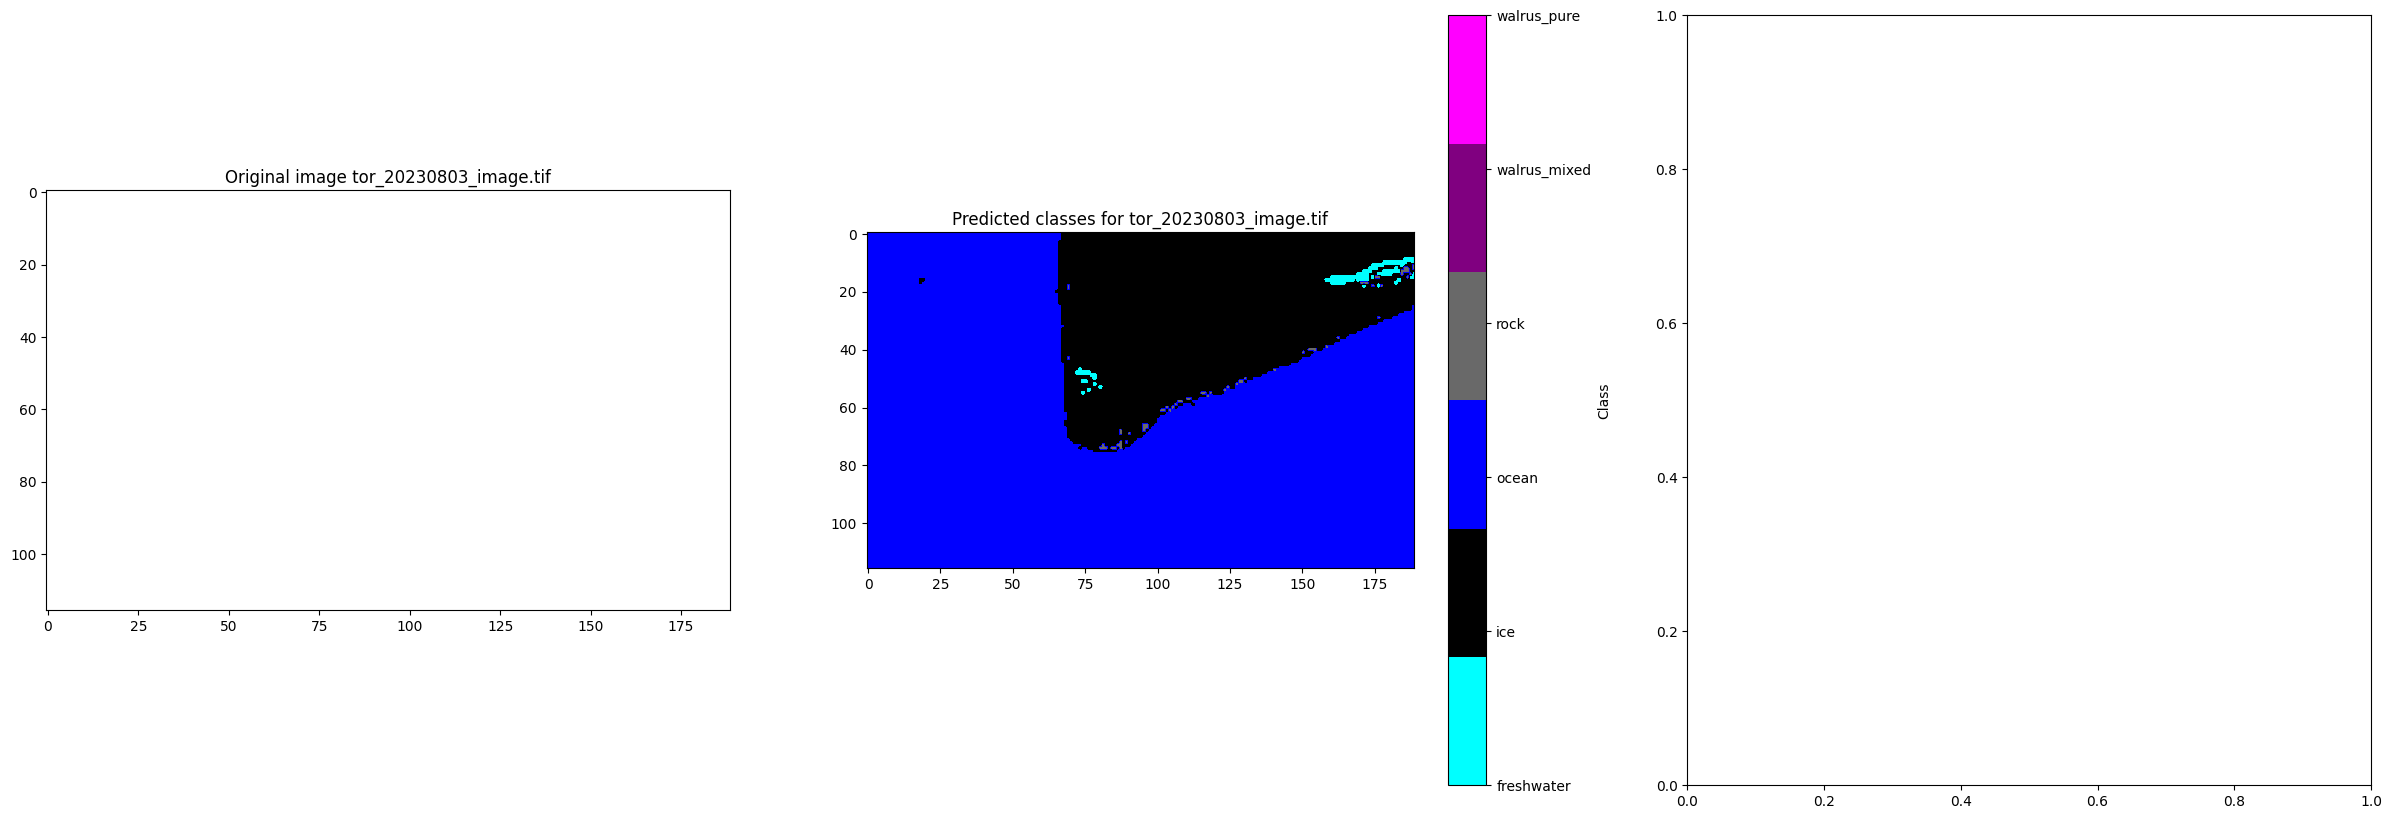

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


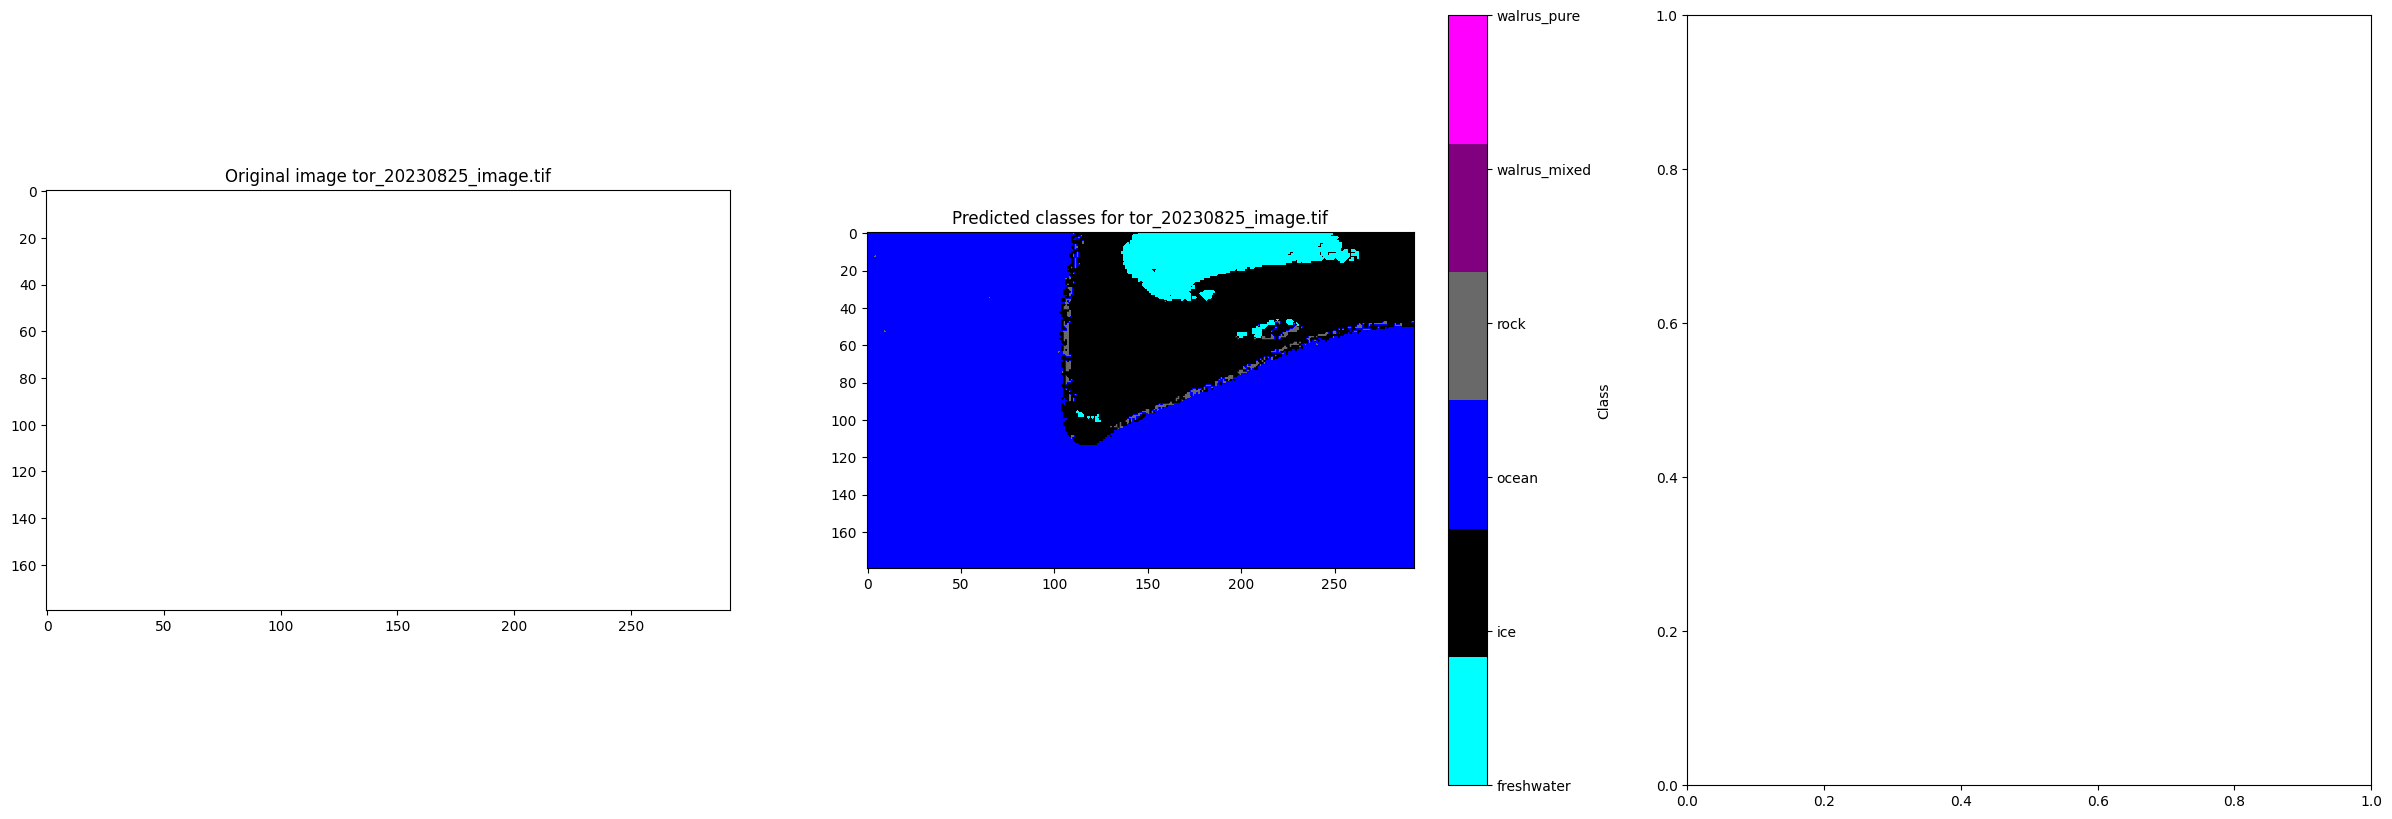

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


In [17]:
# Process and predict unseen images
for image_path in unlabeled_paths:
    predictions = predict_image(image_path, model, le)
    ground_truth_image_path = os.path.join(ground_truth_dir, get_ground_truth_image_path(image_path))
    
    unique_labels = np.unique(predictions)
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    
    with rasterio.open(image_path) as src:
        original_image = src.read((1, 2, 3))  # Assuming original image is a 3-band image (RGB)
    
    axs[0].set_title(f"Original image {os.path.basename(image_path)}")
    show(original_image, ax=axs[0])
    
    axs[1].set_title(f"Predicted classes for {os.path.basename(image_path)}")
    im1 = axs[1].imshow(predictions, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    fig.colorbar(im1, ax=axs[1], ticks=range(len(le.classes_)), label='Class').ax.set_yticklabels(le.classes_)
    

    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [ ]:
# Plot the predicted images side by side with the ground truth images
for image_path, predicted_image in predicted_images.items():
    ground_truth_image_path = os.path.join(image_dir, get_ground_truth_image_path(image_path))
    
    if not os.path.exists(ground_truth_image_path):
        print(f"Ground truth image not found: {ground_truth_image_path}")
        continue
    
    with rasterio.open(ground_truth_image_path) as src:
        ground_truth_image = src.read(1)  # Assuming ground truth is a single-band image
    
    unique_labels = np.unique(predicted_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    axs[0].set_title(f"Predicted classes for {os.path.basename(image_path)}")
    im0 = axs[0].imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    fig.colorbar(im0, ax=axs[0], ticks=range(len(le.classes_)), label='Class').ax.set_yticklabels(le.classes_)
    
    axs[1].set_title(f"Ground truth for {os.path.basename(image_path)}")
    im1 = axs[1].imshow(ground_truth_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    fig.colorbar(im1, ax=axs[1], ticks=range(len(le.classes_)), label='Class').ax.set_yticklabels(le.classes_)
    
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()